# Signals Analysis

In [268]:
### header ###
__author__ = "Jenhan Tao"
__license__ = "BSD"
__email__ = "jenhantao@gmail.com"
%load_ext autoreload
%autoreload 2
### imports ###
import sys
%matplotlib inline
import os
import pandas as pd
import numpy as np
import matplotlib
import threading
import multiprocessing
import matplotlib.pyplot as plt 
import seaborn as sns
from collections import Counter
import matplotlib_venn
import networkx as nx
from networkx.drawing.nx_agraph import graphviz_layout
matplotlib.pylab.rcParams['savefig.dpi'] = 200
sys.setrecursionlimit(3000)
import pickle
from sklearn import preprocessing
import time
import scipy
from sklearn.cross_validation import cross_val_score
from sklearn import tree
import sklearn
from sklearn import cross_validation
sns.set_context('notebook')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
workingDirectory = '/home/jtao/analysis/signals_analysis/'
os.chdir(workingDirectory)

## Functions

In [3]:
def convert_sequences_to_array(sequences):
    '''
    inputs: sequence of nucleotides represented as a string composed of A, C, G, T
    outputs: a list of numpy array representations of a sequence with:
             A = [1, 0, 0, 0]
             C = [0, 1, 0, 0]
             G = [0, 0, 1, 0]
             T = [0, 0, 0, 1]
             
    '''
    nucleotide_array_dict = {'A': [1, 0, 0, 0],
                             'C': [0, 1, 0, 0],
                             'G': [0, 0, 1, 0],
                             'T': [0, 0, 0, 1],
                             'N': [0, 0, 0, 0]}
    sequence_array_list = []
    for seq in sequences:
        seq_array = []
        for nuc in seq:
            seq_array.append(nucleotide_array_dict[nuc])
        seq_array = np.array(seq_array)
        sequence_array_list.append(seq_array)
    return sequence_array_list




In [4]:
def read_fasta(file_path):
    '''
    reads in a fasta file and returns a list of sequence ids and a list of sequences
    inputs: filepath - path to a fasta file
    outputs: sequence_list - a list of sequences
             id_list - a list of ids
    '''
    with open(file_path) as f:
        data = f.readlines()
    id_list = []
    sequence_list = []
    # loop through each sequence
    for line in data:
        if '>' in line:
            seq_id = line.strip()[1:]
            id_list.append(seq_id)
        else:
            seq = line.strip()
            sequence_list.append(seq)
    return sequence_list, id_list



In [5]:
def read_motif_file(motifPath, pseudocount):
    '''
    reads all motif files in a directory 
    inputs: path to a directory containing homer motif files
    outputs: an array of tuples representing each motif
    '''
    name_metadata_dict = {}
    with open(motifPath) as f:
        data = f.readlines()
    name = '.'.join(motifPath.split('/')[-1].split('.')[:-1])
    matrix = []
    metadata = data[0].strip()
    for line in data[1:]:
        tokens = line.strip().split("\t")
        if len(tokens) > 1:
            scores = np.array([float(x) for x in tokens])
            scores = scores + pseudocount
            scores= scores/np.sum(scores)
            matrix.append(scores)
    return (name,np.array(matrix))

In [6]:
def plot_motif_sequence(seq_index,
                        sequence_array_list, 
                        motif_score_dict, 
                        motif_score_rc_dict, 
                        motif_size_dict,
                        threshold = 0,
                        color_dict = None,
                        symmetric_motifs = [],
                        algorithm_plot = False,
                       ):
    '''
    visualize a single sequence using the highest scoring nonoverlapping motifs
    '''
    motif_names = sorted(motif_score_dict.keys())
    seq_array = sequence_array_list[seq_index]
    seq_size = seq_array.shape[0]
    # initialize position_node array
    position_node_array = [[] for x in range(seq_size)]

    # intialize graph
    seq_graph = nx.Graph()

    # initialize
    for motif in motif_names:
        motif_size = motif_size_dict[motif]
        indices = list(range(len(motif_score_dict[motif][seq_index])))
        forward_scores = motif_score_dict[motif][seq_index]
        revcomp_scores = motif_score_rc_dict[motif][seq_index]

        # identify motif instances using score threshold
        filtered_forward_motif_instances = [x for x in zip(indices, forward_scores) if x[1]>threshold]
        filtered_revcomp_motif_instances = [x for x in zip(indices, revcomp_scores) if x[1]>threshold]

        # create graph node for every forward motif instance
        for mi in filtered_forward_motif_instances:
            node_id = str(mi[0]) + '_' + motif
            seq_graph.add_node(node_id, 
                               name=motif,
                               start=mi[0], 
                               end = mi[0] + motif_size, 
                               score=mi[1], 
                               orientation='+')

            # figure out positions motif instance occupies
            start_position = mi[0]
            end_position=start_position + motif_size

            # add node_id to position_node array
            for pos in range(start_position, end_position):
                position_node_array[pos].append(node_id)

        # create graph node for every revcomp motif instance
        for mi in filtered_revcomp_motif_instances:
            node_id = str(mi[0]) + '_' + motif
            seq_graph.add_node(node_id, 
                               name=motif,
                               start=mi[0], 
                               end = mi[0] + motif_size, 
                               score=mi[1], 
                               orientation='-')

            # figure out positions motif instance occupies
            start_position = mi[0]
            end_position=start_position + motif_size

            # add node_id to position_node array
            for pos in range(start_position, end_position):
                position_node_array[pos].append(node_id)

    # figure out which edges to create
    edges_to_add = set()
    for pos in range(len(position_node_array)):
        nodes_at_pos = position_node_array[pos]
        # make sure edges are ordered alphabetically
        # so I don't have to deal with A-B and B-A
        nodes_at_pos.sort() 
        # generate proposed edges
        num_nodes = len(nodes_at_pos)
        for i in range(num_nodes - 1):
            for j in range(i+1, num_nodes):
                id_1 = nodes_at_pos[i]
                id_2 = nodes_at_pos[j]
                edges_to_add.add((id_1,id_2))
    seq_graph.add_edges_from(edges_to_add)

    # find best motif instances

    # loop through nodes and remove motif instances until there are no neighboring motif instances
    num_edges = seq_graph.number_of_edges()
    num_nodes = seq_graph.number_of_nodes()
    
    node_counts = [num_nodes]
    edge_counts = [num_edges]
    motif_instances =[]
    while num_edges > 0:
        # sort nodes by motif score
        sorted_nodes = sorted(seq_graph.nodes(data=True), key=lambda x: x[1]['score'], reverse=True)

        top_node = sorted_nodes[0]
        top_node_id = top_node[0]

        # save motif instance
        motif_instances.append(top_node)

        # remove node and neighbors from graph
        neighbors = seq_graph.neighbors(top_node_id)

        seq_graph.remove_node(top_node_id)
        seq_graph.remove_nodes_from(neighbors)

        num_edges = seq_graph.number_of_edges()
        num_nodes = seq_graph.number_of_nodes()

        node_counts.append(num_nodes)
        edge_counts.append(num_edges)
        
#         print(num_edges, num_nodes)
        
    # create list representation of motifs
    sorted_motif_instances = sorted(motif_instances, key = lambda x:x[1]['start'])
   
    if algorithm_plot:
        with sns.axes_style('ticks'):
            fig, ax1 = plt.subplots()
            ax2 = ax1.twinx()
            ln1 = ax1.plot(list(range(len(node_counts))), 
                     node_counts, 
                     c='red',
                     label = 'Motif Instances')

            ln2 = ax2.plot(list(range(len(edge_counts))), 
                     edge_counts, 
                     c='blue',
                     label = 'Motif Overlaps')
        
            ax1.set_xlabel('# Motifs Selected')
            ax1.set_ylabel('# Motif Instances')
            ax2.set_ylabel('# Motif Overlaps')
            
            lns = ln1+ln2
            labs = [l.get_label() for l in lns]
            ax2.legend(lns, labs, loc=0)
            
    # visualize loci
    if color_dict == None:
        color_dict = dict(zip(motif_names,
                            sns.color_palette("hls", len(motif_names))
                            )
                        )
    with sns.axes_style('ticks'):
        plt.figure(figsize=(16,2))
        for mi in sorted_motif_instances:
            name = mi[1]['name']
            start = mi[1]['start']
            end = mi[1]['end']
            score = mi[1]['score']
            orientation = mi[1]['orientation']

            midpoint = start + (end - start)/2

            color = color_dict[name]
            # plot positions
            if name in symmetric_motifs:
                plt.plot([start, end], [0,0], c=color)
            elif orientation == '+':
                plt.arrow(start, 0, end-start, 0, 
                          color=color, 
                          width=0.1, 
                          head_width=1,
                          length_includes_head=True)
            else:
                plt.arrow(end, 0, start-end, 0, 
                          color=color, 
                          width=0.1, 
                          head_width=1,
                          length_includes_head=True)
    #         plt.plot([start, end], [-1,-1], c=color)
            # plot motif score
            plt.plot([midpoint, midpoint], [0, score], c=color)
            plt.annotate(xy=(midpoint-3.75, 1.5), s=name, size=8, rotation =90, ha='left', va='bottom')
        plt.ylim(-1,14)
        plt.xlim(0,seq_size)
        plt.xlabel('Position')
        plt.ylabel('Motif Score')
        sns.despine()
    
    
    return sorted_motif_instances

In [7]:
def calc_motif_sequence(seq_index,
                        sequence_array_list, 
                        motif_score_dict, 
                        motif_score_rc_dict, 
                        motif_size_dict,
                        threshold = 0,
                        symmetric_motifs = [],
                       ):
    '''
    visualize a single sequence using the highest scoring nonoverlapping motifs
    '''
    motif_names = sorted(motif_score_dict.keys())
    seq_array = sequence_array_list[seq_index]
    seq_size = seq_array.shape[0]
    # initialize position_node array
    position_node_array = [[] for x in range(seq_size)]

    # intialize graph
    seq_graph = nx.Graph()

    # initialize
    for motif in motif_names:
        motif_size = motif_size_dict[motif]
        indices = list(range(len(motif_score_dict[motif][seq_index])))
        forward_scores = motif_score_dict[motif][seq_index]
        revcomp_scores = motif_score_rc_dict[motif][seq_index]

        # identify motif instances using score threshold
        filtered_forward_motif_instances = [x for x in zip(indices, forward_scores) if x[1]>threshold]
        filtered_revcomp_motif_instances = [x for x in zip(indices, revcomp_scores) if x[1]>threshold]

        # create graph node for every forward motif instance
        for mi in filtered_forward_motif_instances:
            node_id = str(mi[0]) + '_' + motif
            seq_graph.add_node(node_id, 
                               name=motif,
                               start=mi[0], 
                               end = mi[0] + motif_size, 
                               score=mi[1], 
                               orientation='+')

            # figure out positions motif instance occupies
            start_position = mi[0]
            end_position=start_position + motif_size

            # add node_id to position_node array
            for pos in range(start_position, end_position):
                position_node_array[pos].append(node_id)

        # create graph node for every revcomp motif instance
        for mi in filtered_revcomp_motif_instances:
            node_id = str(mi[0]) + '_' + motif
            seq_graph.add_node(node_id, 
                               name=motif,
                               start=mi[0], 
                               end = mi[0] + motif_size, 
                               score=mi[1], 
                               orientation='-')

            # figure out positions motif instance occupies
            start_position = mi[0]
            end_position=start_position + motif_size

            # add node_id to position_node array
            for pos in range(start_position, end_position):
                position_node_array[pos].append(node_id)

    # figure out which edges to create
    edges_to_add = set()
    for pos in range(len(position_node_array)):
        nodes_at_pos = position_node_array[pos]
        # make sure edges are ordered alphabetically
        # so I don't have to deal with A-B and B-A
        nodes_at_pos.sort() 
        # generate proposed edges
        num_nodes = len(nodes_at_pos)
        for i in range(num_nodes - 1):
            for j in range(i+1, num_nodes):
                id_1 = nodes_at_pos[i]
                id_2 = nodes_at_pos[j]
                edges_to_add.add((id_1,id_2))
    seq_graph.add_edges_from(edges_to_add)

    # find best motif instances

    # loop through nodes and remove motif instances until there are no neighboring motif instances
    num_edges = seq_graph.number_of_edges()
    num_nodes = seq_graph.number_of_nodes()
    
    node_counts = [num_nodes]
    edge_counts = [num_edges]
    motif_instances =[]
    while num_edges > 0:
        # sort nodes by motif score
        sorted_nodes = sorted(seq_graph.nodes(data=True), key=lambda x: x[1]['score'], reverse=True)

        top_node = sorted_nodes[0]
        top_node_id = top_node[0]

        # save motif instance
        motif_to_save = top_node[1]
        if motif_to_save['name'] in symmetric_motifs:
            motif_to_save['orientation'] = '|'
        motif_instances.append(motif_to_save)

        # remove node and neighbors from graph
        neighbors = seq_graph.neighbors(top_node_id)

        seq_graph.remove_node(top_node_id)
        seq_graph.remove_nodes_from(neighbors)

        num_edges = seq_graph.number_of_edges()
        num_nodes = seq_graph.number_of_nodes()

        node_counts.append(num_nodes)
        edge_counts.append(num_edges)
        
       
    # create list representation of motifs
    sorted_motif_instances = sorted(motif_instances, key = lambda x:x['start'])
   
    
    
    return sorted_motif_instances

In [8]:
def project_database(prefix, database):
    '''
    projects a database of sequences and their corresponding motif paths
    according to a prefix. 
    input: prefix - a string representing a motif and its orientation,
           database - a dictionary containing lists of motif paths
                      corresponding to each sequence
                      {seq_id:[motif_sequences...]}
    output: returns the projected database
    '''
    projected_database = {}
    for seq_id in database:
        projected_paths = []
        motif_paths = database[seq_id]
        for path in motif_paths:
            if prefix in path:
                ind = path.index(prefix)
                proj_path = path[ind+1:]
                if len(proj_path) > 0:
                    projected_paths.append(proj_path)
#         print(prefix, (motif_paths), projected_paths)
        if len(projected_paths) > 0:
            projected_database[seq_id] = projected_paths
        
    return projected_database

In [9]:
def find_frequent_motifs(database, support_level):
    '''
    Finds motifs in database that exceeds support level. 
    For each sequence, collapses the counts of all motif paths corresponding to that sequence
    
    inputs: database - a dictionary containing lists of motif paths
                      corresponding to each sequence
            support_level - number of times a motif must appear to be counted
    outputs: 
    '''
    motif_count_dict = {}
    
    for seq_id in database:
        motifs_in_seq = set()
        motif_paths = database[seq_id]
        for path in motif_paths:
            for motif in path:
                motifs_in_seq.add(motif)
        for m in motifs_in_seq:
            if m in motif_count_dict:
                motif_count_dict[m] += 1
            else:
                motif_count_dict[m] = 1
    
    frequent_motifs = [(x, motif_count_dict[x]) for x in motif_count_dict if motif_count_dict[x] >= support_level]
    sorted_frequent_motifs = sorted(frequent_motifs, key = lambda x:x[1], reverse=True)
    to_return = [x[0] for x in sorted_frequent_motifs]
#     print(len(database), sorted_frequent_motifs[:10])
    return to_return

In [10]:
def motif_prefix_span(prefix, database, support_level):
    '''
    Finds frequents sequences of motifs in a datase of sequences and their corresponding
    motif paths
    inputs: prefix - a string representing a motif and its orientation
            database - a dictionary containing lists of motif paths corresponding to each sequence
            support level - number of times a motif must appear to be counted
    outputs: a list of frequent patterns
    '''
#     print('***', prefix, len(database))
    if len(database) >= support_level:
        frequent_motifs = find_frequent_motifs(database, support_level)
    else:
        frequent_motifs = []
    to_return = []
    if len(frequent_motifs) > 0:
        for fm in frequent_motifs:
            new_pattern = prefix + [fm]
            projected_database = project_database(fm, database)
            
            fm_results = motif_prefix_span(new_pattern, 
                                           projected_database, 
                                           support_level)
            to_return = to_return +  fm_results 

            to_return.append(new_pattern)
    return to_return

In [11]:
def calc_multi_motif_sequence(seq_array, 
                              forward_score_dict, 
                              reverse_score_dict, 
                              motif_size_dict,
                              score_threshold = 0,
                              distance_threshold = 200,
                              symmetric_motifs = []
                             ):
    '''
    '''
    motif_names = sorted(forward_score_dict.keys())
    seq_size = seq_array.shape[0]
    # initialize position_node array
    position_node_array = [[] for x in range(seq_size)]

    # intialize graph
    seq_graph = nx.DiGraph()

    # initialize
    for motif in motif_names:
        motif_size = motif_size_dict[motif]
        indices = list(range(len(forward_score_dict[motif])))
        forward_scores = forward_score_dict[motif]
        revcomp_scores = reverse_score_dict[motif]

        # identify motif instances using score score_threshold
        filtered_forward_motif_instances = [x for x in zip(indices, forward_scores) if x[1]>score_threshold]
        filtered_revcomp_motif_instances = [x for x in zip(indices, revcomp_scores) if x[1]>score_threshold]

        # create graph node for every forward motif instance
        for mi in filtered_forward_motif_instances:
            node_id = str(mi[0]) + ' ' + motif + ' +'
            seq_graph.add_node(node_id, 
                               name=motif,
                               start=mi[0], 
                               end = mi[0] + motif_size, 
                               score=mi[1], 
                               orientation='+')

            # figure out positions motif instance occupies
            start_position = mi[0]
            end_position=start_position + motif_size

            # add node_id to position_node array
            for pos in range(start_position, end_position):
                position_node_array[pos].append(node_id)

        # create graph node for every revcomp motif instance
        for mi in filtered_revcomp_motif_instances:
            node_id = str(mi[0]) + ' ' + motif + ' -'
            seq_graph.add_node(node_id, 
                               name=motif,
                               start=mi[0], 
                               end = mi[0] + motif_size, 
                               score=mi[1], 
                               orientation='-')

            # figure out positions motif instance occupies
            start_position = mi[0]
            end_position=start_position + motif_size

            # add node_id to position_node array
            for pos in range(start_position, end_position):
                position_node_array[pos].append(node_id)

    # add edges
    all_nodes = seq_graph.nodes(data=True)
    edges_to_add = []
    for node in all_nodes:
        # find the first nonoverlapping motif(s)
        end_pos = node[1]['end']
        first_neighbor_pos = end_pos
        candidate_neighbors = []
        while len(candidate_neighbors) < 1 and first_neighbor_pos < seq_size:
            candidate_neighbors = position_node_array[first_neighbor_pos]
            first_neighbor_pos += 1
            
        # find largest motif amongst the first nonoverlapping motif(s)
        max_size_end = -1
        max_size_start = -1
        for n in candidate_neighbors:
            neighbor = seq_graph.node[n]
            neighbor_end = neighbor['end']
            neighbor_start = neighbor['start']
            if neighbor_end > max_size_end:
                max_size_end = neighbor_end
                max_size_start = neighbor_start
        # identify all motifs that overlap with the first largest nonoverlapping motif(s)
        for pos in range(max_size_start, max_size_end):
            candidate_neighbors = candidate_neighbors + position_node_array[pos]
        candidate_neighbors = set(candidate_neighbors)
        
        for n in candidate_neighbors:
            neighbor = seq_graph.node[n]
            neighbor_start = neighbor['start']
            if neighbor_start >= end_pos:
                edges_to_add.append((node[0], n))
    seq_graph.add_edges_from(edges_to_add)

    # creat start node and connect all nodes with 0 incoming edges
    start_edges = []
    for node_id, in_degree in seq_graph.in_degree_iter():
        if in_degree == 0:
            start_edges.append(('start', node_id))
            
    # create end node and connect all nodes with 0 outgoing edges
    end_edges = []
    for node_id, out_degree in seq_graph.out_degree_iter():
        if out_degree == 0:
            end_edges.append((node_id, 'end'))
    
    seq_graph.add_edges_from(start_edges)
    seq_graph.add_edges_from(end_edges)
    
    # generate all paths from start to end node
    paths = nx.all_simple_paths(seq_graph, 'start', 'end')
    
    # add data to list of paths
    id_score_dict = nx.get_node_attributes(seq_graph, 'score')
    paths_with_data = []
    paths_without_data = []
    counter = 0
    for p in paths:
        
        if counter > 1000:
            print('Too many paths!!!')
            return seq_graph, [], [] 
        counter += 1
        
        current_p_with_data = []
        current_p_without_data = []
        for n in p:
#             if n == 'start':
#                 motif_name = 'start'
#                 orientation = '|'
#                 score = score_threshold
#             elif n == 'end':
#                 motif_name = 'end'
#                 orientation = '|'
#                 score = score_threshold
#             else:
            # exclude end and start nodes which were created just for creating paths
            if not n== 'start' and not n == 'end':
                tokens = n.split()
                motif_name = tokens[1]
                orientation = tokens[2]
                score = id_score_dict[n]
                
                n_with_data = (motif_name, orientation, score)
                current_p_with_data.append(n_with_data)
                current_p_without_data.append(motif_name + ' ' + orientation)
        paths_with_data.append(current_p_with_data)
        paths_without_data.append(current_p_without_data)

    return seq_graph, paths_with_data, paths_without_data

In [12]:
# def create_pattern_sequence_table(frequent_patterns, database):
#     '''
#     Constructs a matrix summarizing which sequences contains a frequent motif pattern
#     '''
#     sorted_ids = sorted(database.keys())
#     pattern_names = [' * '.join(x) for x in frequent_patterns]
#     sequence_pattern_table = pd.DataFrame(np.zeros((len(sorted_ids), len(pattern_names))),
#                                           index = sorted_ids,
#                                           columns = pattern_names)
#     for i in range(len(frequent_patterns)):
#         if i % 10 == 0:
#             print(i)
#         pattern = frequent_patterns[i]
#         pattern_name = pattern_names[i]
#         for seq_id in sorted_ids:
#             motif_paths = database[seq_id]
#             has_pattern = False
#             for path in motif_paths:
#                 path_iter = iter(path)
#                 has_pattern = all([m in path_iter for m in pattern])
#                 if has_pattern:
#                     sequence_pattern_table.ix[seq_id, pattern_name] = 1
# #                     break
#     return sequence_pattern_table
            
        

In [278]:
# split data into GC content matched training and test data
def get_split(features, labels, test_size):
    '''
    feature: 2D array (samples x features)
    labels: 1D boolean array (samples x)
    test_size: fraction of data to test on
    '''
    
    ### match GC content of samples labelled True with those labelled False by thowing out False samples
    # retrieve sequences using index of labels
    index_label_tuples = tuple(zip(labels.index.values, labels.values))
    
    true_ids = [x[0] for x in index_label_tuples if x[1]]
    
    false_ids = [x[0] for x in index_label_tuples if not x[1]]
       
    filtered_ids = true_ids + false_ids
    filtered_features = features[features.index.isin(filtered_ids)]
    filtered_labels = labels[labels.index.isin(filtered_ids)]

    if test_size <= 0.5:
        training_indices, test_indices = next(iter(
                sklearn.cross_validation.StratifiedKFold(filtered_labels, int(1/test_size), shuffle=True)))
    else:
        test_indices, training_indices = next(
            iter(sklearn.cross_validation.StratifiedKFold(filtered_labels, int(1/(1-test_size)), shuffle=True)))
    training_ids = [filtered_ids[i] for i in training_indices]
    test_ids = [filtered_ids[i] for i in test_indices]
    
    training_features = filtered_features[filtered_features.index.isin(training_ids)]
    test_features = filtered_features[filtered_features.index.isin(test_ids)]
    training_labels = filtered_labels[filtered_labels.index.isin(training_ids)]
    test_labels = filtered_labels[filtered_labels.index.isin(test_ids)]
    
    return training_features, test_features, training_labels, test_labels
    

In [78]:
def create_pattern_sequence_table(frequent_patterns, 
                                         database):
    '''
    Constructs a matrix summarizing which sequences contains a frequent motif pattern
    '''

    lock = threading.Lock()  
    thread_list = []
    
    has_pattern_dict = {}
    sorted_ids = sorted(database.keys())   

    for i in range(len(frequent_patterns)):
        try:
            pattern = frequent_patterns[i]
            current_thread = threading.Thread(target = find_pattern,
                             args=(pattern,
                                   sorted_ids,
                                   database,
                                   has_pattern_dict,
                                   lock
                                   )      
                            )
            thread_list.append(current_thread)
            current_thread.start()
        finally:
            if lock.locked_lock():
                lock.release()
    for current_thread in thread_list:
        current_thread.join()


    sequence_pattern_table = pd.DataFrame(has_pattern_dict,
                                          index = sorted_ids)
    return sequence_pattern_table

In [81]:
def find_pattern(pattern,
                 sorted_ids,
                 database,
                 result_dict,
                 thread_lock
                 ):
    pattern_name = ' * '.join(pattern)
    has_pattern_list = []
    start = time.time()
    for seq_id in sorted_ids:
        motif_paths = database[seq_id]
        has_pattern = False
        for path in motif_paths:
            path_iter = iter(path)
            has_pattern = all([m in path_iter for m in pattern])
            if has_pattern:
                break
        if has_pattern:
            has_pattern_list.append(1)
        else:
            has_pattern_list.append(0)

    while thread_lock.locked_lock():
        time.sleep(0.05)
    thread_lock.acquire()
    
    result_dict[pattern_name] = has_pattern_list
    print('done searching for', pattern_name, time.time() - start)
    if thread_lock.locked_lock():
        thread_lock.release()


## Identify Acessible Promoters

In [13]:
# read in peak data data
summary_frame = pd.read_csv('./group_atac_summary.tsv' , sep='\t')
summary_frame = summary_frame.fillna('0')
for col in summary_frame.columns[5:]:
    floatValues = []
    for val in summary_frame[col].values.astype(str):
        if ',' in val:
            maxVal = np.mean([float(x) for x in val.split(',')])
            floatValues.append(maxVal)
        else:
            floatValues.append(float(val))
    summary_frame[col] = floatValues
summary_frame.index = summary_frame['chr'] + ':' + (summary_frame['start'] -1).astype(str) + '-' + summary_frame['end'].astype(str)

# remove peaks in unknown/random chromosomes
summary_frame = summary_frame[~summary_frame['chr'].str.contains('random')]
summary_frame = summary_frame[~summary_frame['chr'].str.contains('Un')]

columns = summary_frame.columns.values
columns = [x.replace('c57bl6_','') for x in columns]
summary_frame.columns = columns

In [14]:
merged_frame = pd.read_csv('./merged_atac_peaks_filtered_resized.tsv', sep='\t')
merged_frame.index = merged_frame.ix[:,0].values

# filter away peaks in unused chromsomes
filtered_frame = merged_frame[
             ~(merged_frame['chr'].str.contains('chrY')) & 
             ~(merged_frame['chr'].str.contains('chrM')) &
             ~(merged_frame['chr'].str.contains('random')) &
             ~(merged_frame['chr'].str.contains('Un'))]

In [15]:
# read in annotated frame
annotated_frame = pd.read_csv('./annotated_atac_peaks.tsv', sep='\t')
annotated_frame.index = annotated_frame['Chr'] + ':' + (annotated_frame['Start'] -1).astype(str) + '-' + annotated_frame['End'].astype(str)

# get promoter associated peaks and associated gene names
annotated_frame['Annotation'] = [x.split(' ')[0] for x in annotated_frame['Annotation'].astype(str)]

columns = list(annotated_frame.columns.values)
columns = columns[:4] + ['Annotation', 'Gene Name'] + [x for x in columns[1:] if 'Tag Count' in x]
annotated_frame = annotated_frame[columns]
columns[0] = 'PeakID'
columns = [x.split('/')[-2].split(' ')[0] if '/' in x else x for x in columns]
annotated_frame.columns = columns

annotated_mean_frame = annotated_frame[[]]

treatments = set([x.split('_')[3] for x in annotated_frame.columns if '_' in x])
print('treatment loop')
for treatment in treatments:
    print(treatment)
    treatment_cols = [x for x in columns if treatment in x]
    annotated_mean_frame[treatment] = annotated_frame[treatment_cols].mean(axis=1).values

promoter_ids = annotated_frame[annotated_frame['Annotation'].str.contains('promoter')].index.values
annotated_promoter_frame = annotated_mean_frame[annotated_mean_frame.index.isin(promoter_ids)]

treatment loop
KLA-1h
IFNg-1h
TGFbeta-1h
PamCSK-1h
R848-1h
Veh
IL4-1h


/gpfs/data01/glasslab/home/jtao/software/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [16]:
promoter_ids = annotated_frame[annotated_frame['Annotation'].str.contains('promoter')].index.values
annotated_promoter_frame = annotated_mean_frame[annotated_mean_frame.index.isin(promoter_ids)]

In [17]:
id_gene_dict = dict(zip(promoter_ids, annotated_frame.ix[promoter_ids,'Gene Name'].values))
gene_id_dict = dict(zip(annotated_frame.ix[promoter_ids,'Gene Name'].values, promoter_ids))



## Read in Expression Data

In [18]:
diff_expression_frame = pd.read_csv('./edgeR_out.tsv', sep='\t')
columns = diff_expression_frame.columns.values
columns[0] = 'refseq'
columns[7] = 'gene'

columns = [x.lower() for x in columns]
diff_expression_frame.columns = columns

diff_expression_frame = diff_expression_frame.ix[:,['refseq', 'chr', 'start', 'end', 'gene'] + [x for x in diff_expression_frame.columns if 'vs.' in x]]
diff_expression_frame['gene'] = [x.split('|')[0] for x in diff_expression_frame['gene'].values]

In [103]:
rpkm_frame = pd.read_csv('./rpkm.tsv', sep='\t')
columns = rpkm_frame.columns.values
columns[0] = 'Refseq'
columns[7] = 'Gene'
rpkm_frame.columns = columns
rpkm_frame['All Gene Names'] = rpkm_frame['Gene'].values
rpkm_frame['Gene'] = [x.split('|')[0] for x in rpkm_frame['Gene'].values]
rpkm_frame.index = rpkm_frame['Gene'].values
# rpkm_frame.drop('chr', axis=1, inplace=True)
# rpkm_frame.drop('start', axis=1, inplace=True)
# rpkm_frame.drop('end', axis=1, inplace=True)
rpkm_frame.drop('strand', axis=1, inplace=True)
rpkm_frame.drop('Length', axis=1, inplace=True)
rpkm_frame.drop('Copies', axis=1, inplace=True)
conditions = set(sorted([x.split('/')[-1].split('_')[3] for x in rpkm_frame.columns if 'tag_directories' in x]))
rpkm_mean_frame = rpkm_frame[['Refseq', 'Gene', 'All Gene Names']]
for condition in conditions:
    current_cols = [x for x in rpkm_frame.columns if condition in x]
    mean_vals = rpkm_frame[current_cols].mean(axis=1)
    rpkm_mean_frame[condition] = mean_vals
    

/gpfs/data01/glasslab/home/jtao/software/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


## Read In Motifs

In [21]:
pseudocount = 0.001
motif_file_path = '/gpfs/data01/glasslab/home/jtao/analysis/jaspar_analysis/curated_motifs/'
all_motifs = []

for m in os.listdir(motif_file_path):
    if '.motif' in m:
        motif = read_motif_file(motif_file_path + '/' + m, pseudocount)
        all_motifs.append(motif)
# sort motifs by name
all_motifs.sort(key=lambda x:x[0])

fasta_path = './merged_atac_peaks_filtered_resized.fasta'

sequence_list, id_list = read_fasta(fasta_path)

# convert strings to arrays
sequence_array_list = convert_sequences_to_array(sequence_list)

motif_size_dict = {}
for motif in all_motifs:
    name = motif[0]
    size = motif[1].shape[0]
    if '.' in name:
        name = '.'.join(name.split('.')[:-1])
    motif_size_dict[name] = size

motif_names = sorted(motif_size_dict.keys())

## Identify Expressed TFs and Motifs

#### Read in motif gene mapping

In [22]:
gene_motif_dict = {}
with open('/gpfs/data01/glasslab/home/jtao/analysis/jaspar_analysis/clustered_motifs/motifGene.txt') as f:
    data = f.readlines()
for line in data:
    tokens = line.strip().split()
    motif = tokens[0]
    genes = tokens[1].split('|')
    if motif in motif_size_dict:
        for g in genes:
            if g in gene_motif_dict:
                gene_motif_dict[g.upper()].append(motif)
            else:
                gene_motif_dict[g.upper()] = [motif]

### Plot # of motifs vs expression threshold

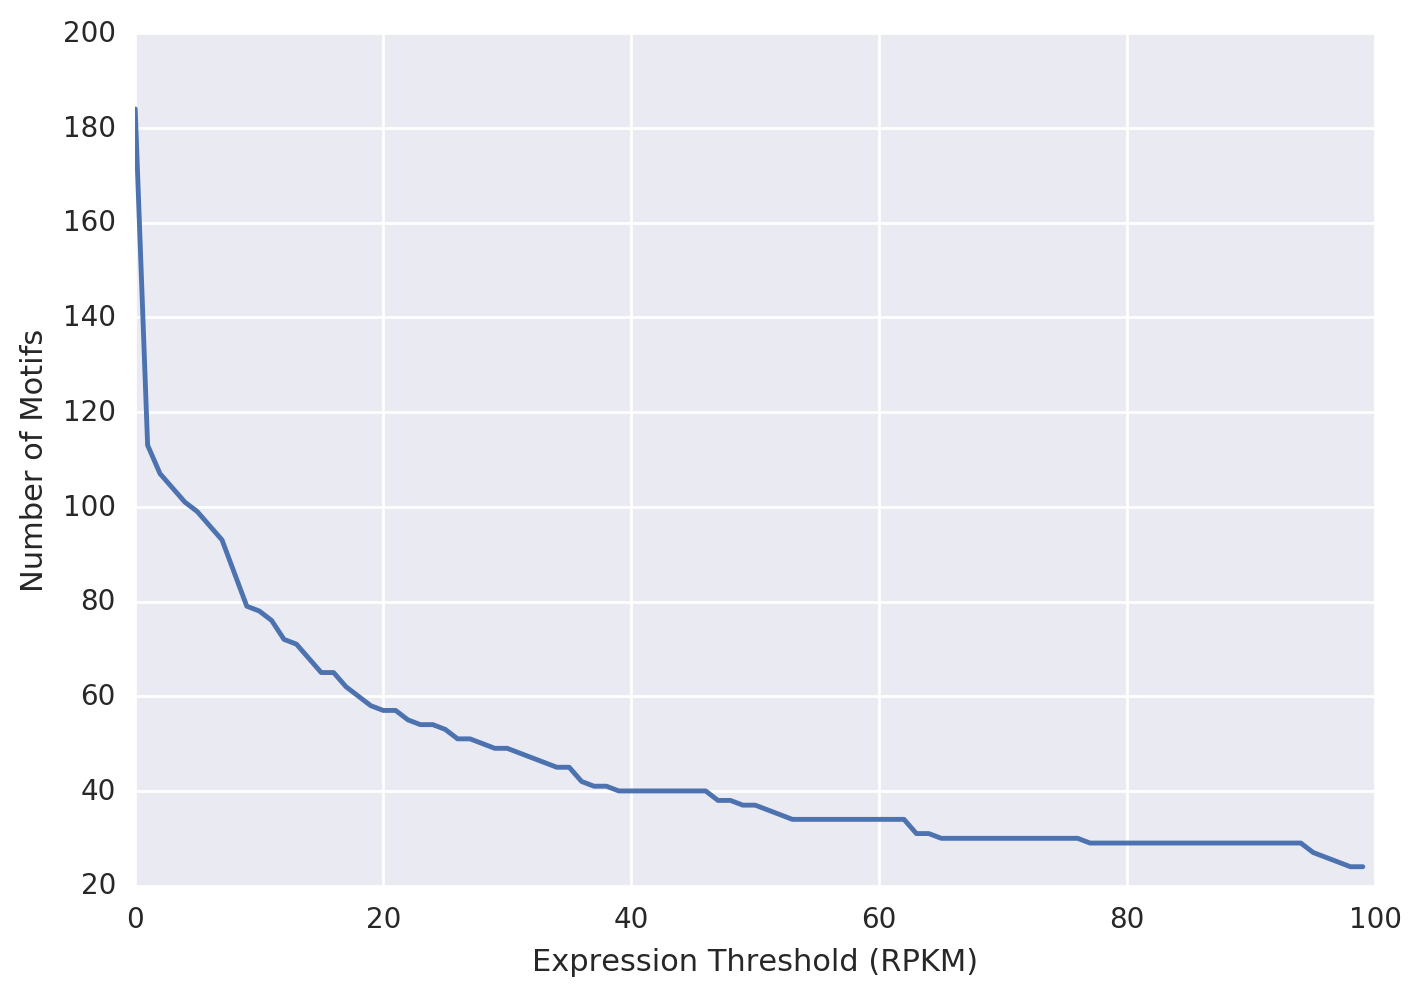

In [23]:
expression_threshold = 16
# thresholds = [1,2,4,8,16,32,64,128]
thresholds = range(100)
num_motifs = []
for expression_threshold in thresholds:
    motifs_at_threshold = []
    gene_names = rpkm_mean_frame[
        rpkm_mean_frame.ix[:,2:].max(axis=1) >= expression_threshold
                    ].ix[:,'All Gene Names'].values
    for gn in gene_names:
        genes = gn.upper().split('|')
        for g in genes:
            if g in gene_motif_dict:
                motifs_at_threshold += gene_motif_dict[g]
    motifs_at_threshold = sorted(set(motifs_at_threshold))
    num_motifs.append(len(motifs_at_threshold))
plt.plot(thresholds, num_motifs) 
plt.xlabel('Expression Threshold (RPKM)')
plt.ylabel('Number of Motifs')

In [24]:
expression_threshold = 20
motifs_to_include = []
gene_names = rpkm_mean_frame[
    rpkm_mean_frame.ix[:,2:].max(axis=1) >= expression_threshold
                ].ix[:,'All Gene Names'].values
for gn in gene_names:
    genes = gn.upper().split('|')
    for g in genes:
        if g in gene_motif_dict:
            motifs_to_include += gene_motif_dict[g]
motifs_to_include = sorted(set(motifs_to_include))
print(len(set(motifs_to_include)))

57


In [25]:
for m in motifs_to_include:
    print(m)

ATF4
Arid5a
Bcl6
CEBP-related_1_merged
CEBP-related_2_merged
CENPB
CREB-related_1_merged
Ddit3::Cebpa
E2F-related_1_merged
EGR1
Ets-related_1_merged
Ets-related_2_merged
Forkhead_1_merged
HD-CUT_1_merged
Hairy-related_1_merged
IRF1
IRF2
Interferon-regulatory_1_merged
Jun-related_1_merged
Jun-related_2_merged
MAFG
MAFG::NFE2L1
Maf-related_1_merged
More_1_merged
More_3_merged
NF-kappaB-related_1_merged
NF-kappaB-related_2_merged
NFIL3
NFYA
NRF1
Nfe2l2
Nr1h3::Rxra
Nuclear_1_merged
PAS_1_merged
POU_2_merged
PPARG
PRDM1
Paired-related_3_merged
RUNX1
RXR-related_1_merged
RXR-related_3_merged
Regulators_1_merged
SRF
STAT1::STAT2
STAT_1_merged
Steroid_2_merged
Steroid_3_merged
TALE-type_1_merged
TBrain-related_1_merged
TP53
Three-zinc_1_merged
Three-zinc_3_merged
XBP1
YY1
ZBTB7A
bHLH-ZIP_1_merged
p53-related_1_merged


## Read Motif Scores

### All Motif Scores

In [28]:
motif_score_dict = {}
motif_score_rc_dict = {}
for f in sorted([x for x in os.listdir('./motif_scores') if x.split('.')[0] in motifs_to_include]):
    motif_name = f.split('.')[0]
    if 'rc' in f:
        print('reading', motif_name)
        motif_score_rc_dict[motif_name] = pickle.load(open('./motif_scores/'+f, 'rb'))
    else:
        motif_score_dict[motif_name] = pickle.load(open('./motif_scores/'+f, 'rb'))

reading ATF4
reading Arid5a
reading Bcl6
reading CEBP-related_1_merged
reading CEBP-related_2_merged
reading CENPB
reading CREB-related_1_merged
reading Ddit3::Cebpa
reading E2F-related_1_merged
reading EGR1
reading Ets-related_1_merged
reading Ets-related_2_merged
reading Forkhead_1_merged
reading HD-CUT_1_merged
reading Hairy-related_1_merged
reading IRF1
reading IRF2
reading Interferon-regulatory_1_merged
reading Jun-related_1_merged
reading Jun-related_2_merged
reading MAFG
reading MAFG::NFE2L1
reading Maf-related_1_merged
reading More_1_merged
reading More_3_merged
reading NF-kappaB-related_1_merged
reading NF-kappaB-related_2_merged
reading NFIL3
reading NFYA
reading NRF1
reading Nfe2l2
reading Nr1h3::Rxra
reading Nuclear_1_merged
reading PAS_1_merged
reading POU_2_merged
reading PPARG
reading PRDM1
reading Paired-related_3_merged
reading RUNX1
reading RXR-related_1_merged
reading RXR-related_3_merged
reading Regulators_1_merged
reading SRF
reading STAT1::STAT2
reading STAT_1_mer

### Top Motif Scores

In [29]:
topMotifScore_frame = pd.read_csv('./top_motif_scores/merged_atac_peaks_filtered_resized_motif_scores.tsv', 
                    sep='\t',
                    index_col= 0)

## Identify Symmetric Motifs

In [30]:
num_sequence_to_sample = 100
num_seqs = len(sequence_array_list)
mean_pearsons = []
motif_symmetryPearson_dict = {}
for motif in sorted(motif_score_dict.keys()):
    
    pearsons = []
    for i in range(num_sequence_to_sample):
        index = np.random.randint(0,num_seqs)

        forward_scores = motif_score_dict[motif][index]
        reverse_scores = motif_score_rc_dict[motif][index]

        pearson, pval = scipy.stats.pearsonr(forward_scores, reverse_scores)
        pearsons.append(pearson)
    mean_pearson = np.mean(pearsons)
    mean_pearsons.append(mean_pearson)
    motif_symmetryPearson_dict[motif] = mean_pearson
symmetric_motifs = [x for x in motif_symmetryPearson_dict if motif_symmetryPearson_dict[x] > 0.8]


## Visualize Diff Expressed Genes

In [31]:
diff_expressed_genes = diff_expression_frame[
                                             (diff_expression_frame['veh-1h vs. ifng-1h adj. p-value'] < 0.05) |
                                             (diff_expression_frame['veh-1h vs. kla-1h adj. p-value'] < 0.05) |
                                             (diff_expression_frame['ifng-1h vs. kla-1h adj. p-value'] < 0.05)
                                            ]['gene'].values



# diff_expressed_genes = diff_expression_frame[diff_expression_frame[
#         [x for x in diff_expression_frame.columns if 'adj. p-value' in x]].min(axis=1) < 0.05
#                                             ]['gene'].values

(1995, 3)


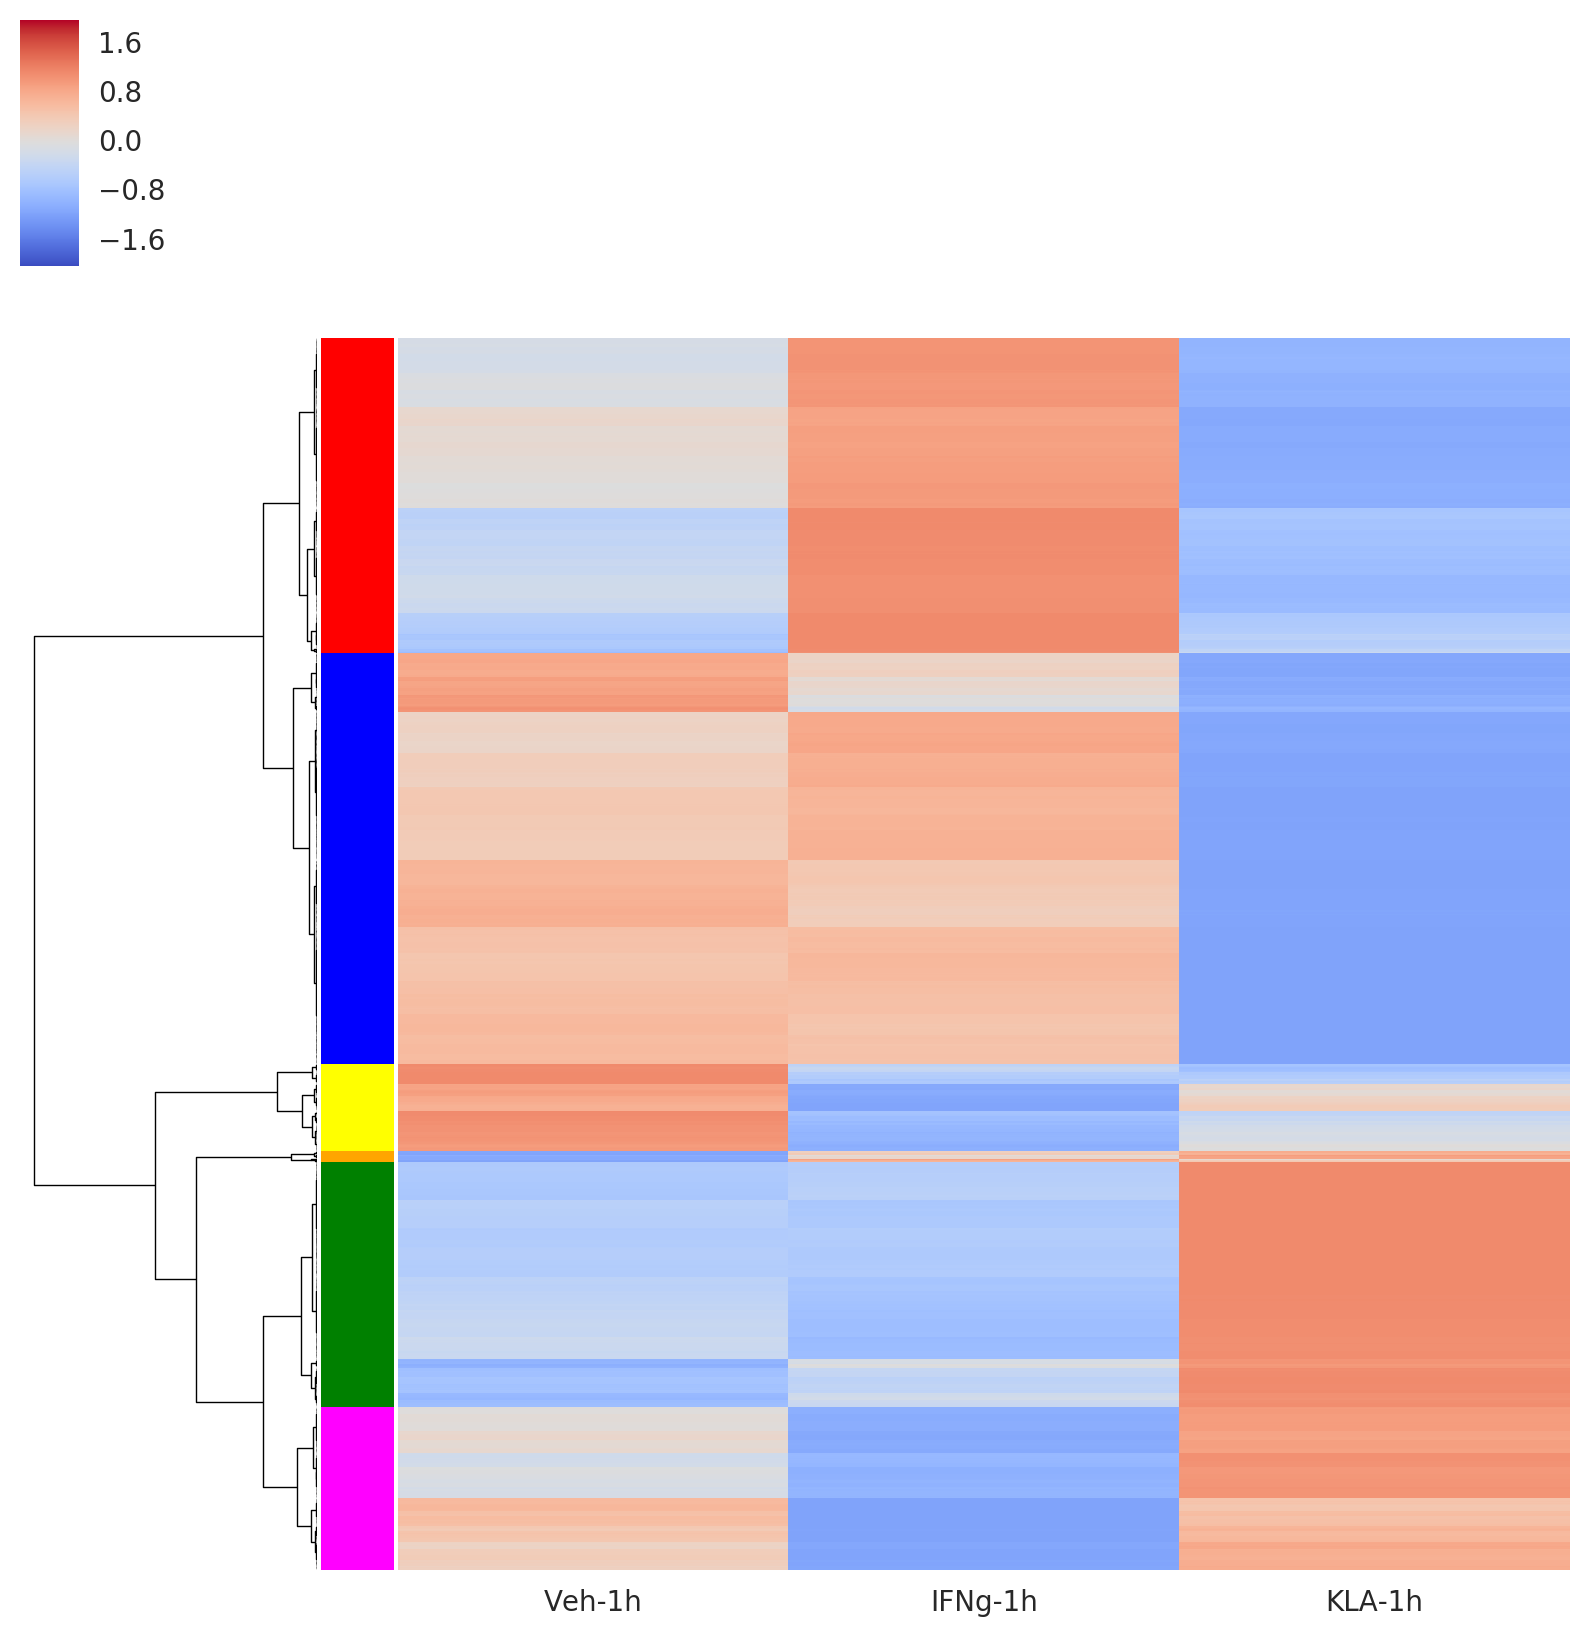

In [32]:
numRowClusters = 6
colorDict = dict(zip(range(numRowClusters),['red', 'blue', 'yellow', 'orange', 'green', 'magenta', 'grey']))

data = rpkm_mean_frame[(rpkm_mean_frame['Gene'].isin(diff_expressed_genes)) &
                (rpkm_mean_frame.ix[:,['Veh-1h', 'IFNg-1h', 'KLA-1h']].max(axis=1) >= 16)].ix[:,['Veh-1h', 'IFNg-1h', 'KLA-1h']]


cg=sns.clustermap(data,
               yticklabels=False,
               col_cluster=False,
               row_cluster=True,
               vmin=-2,
               vmax=2,
               cmap='coolwarm',
               z_score = 0,
               metric = 'correlation',
               method='centroid'
                  
              )
plt.close()
row_linkage = cg.dendrogram_row.linkage

row_flatCluster = scipy.cluster.hierarchy.fcluster(row_linkage, numRowClusters, criterion="maxclust")

row_colors = [colorDict[row_flatCluster[i] -1] for i in range(len(data.index))]
sns.clustermap(data, 
                row_linkage = row_linkage,
                row_colors = row_colors,
                yticklabels = False,
                col_cluster=False,
                vmin=-2,
                vmax=2,
                cmap='coolwarm',
               z_score = 0,
)

print(data.shape)

In [33]:
# ['red', 'blue', 'yellow', 'orange', 'green', 'magenta']
cluster_name_dict = {1:'IFNg Specific',2:'IFNg Specific',3:'KLA Down',4:'Veh Specific', 5:'IFNg Down', 6:'KLA Specific'}

In [34]:
gene_cluster_dict = dict(zip(data.index.values, row_flatCluster))
cluster_genes_dict = {x:[] for x in range(1,numRowClusters+1)}
for gene in gene_cluster_dict:
    cluster = gene_cluster_dict[gene] 
    cluster_genes_dict[cluster].append(gene)

In [35]:
id_sequence_array_dict = dict(zip(id_list, sequence_array_list))

In [36]:
cluster_promoterID_dict = {}
promoterID_cluster_dict = {}
for cluster in cluster_genes_dict:
    cluster_genes = cluster_genes_dict[cluster]
    cluster_seq_ids = []
    
    for g in cluster_genes:
        if g in gene_id_dict:
            promoter_id = gene_id_dict[g]
            cluster_seq_ids.append(promoter_id)
            promoterID_cluster_dict[promoter_id] = cluster
    if len(cluster_seq_ids) > 50:
        cluster_promoterID_dict[cluster] = cluster_seq_ids
        print(cluster)
        print(len(cluster_genes), len(set(cluster_genes)))
        print(len(cluster_seq_ids), len(set(cluster_seq_ids)))



1
510 510
419 419
2
665 665
536 536
3
142 142
120 120
5
397 397
318 318
6
264 264
221 221


## Visualize Differential ATAC Peaks

In [37]:
diff_atac_frame = pd.read_csv('./edgeR_atac_out.tsv', sep='\t')
columns = diff_atac_frame.columns.values
columns[0] = 'PeakID'
diff_atac_frame.columns = columns
diff_atac_frame.index = diff_atac_frame['Chr'] + ':' + (diff_atac_frame['Start'] -1).astype(str) + '-' + diff_atac_frame['End'].astype(str)


diff_atac_frame = diff_atac_frame.ix[:,['PeakID', 'Chr', 'Start', 'End'] + [x for x in diff_atac_frame.columns if 'vs.' in x]]

columns = diff_atac_frame.columns.values
columns = [x.lower() for x in columns]
diff_atac_frame.columns = columns

In [38]:
diff_bound_peaks = diff_atac_frame[
                                     (diff_atac_frame['veh vs. ifng-1h adj. p-value'] < 0.05) |
                                     (diff_atac_frame['veh vs. kla-1h adj. p-value'] < 0.05) |
                                     (diff_atac_frame['ifng-1h vs. kla-1h adj. p-value'] < 0.05)
                                    ].index.values



# diff_bound_peaks = diff_atac_frame[diff_atac_frame[
#         [x for x in diff_atac_frame.columns if 'adj. p-value' in x]].min(axis=1) < 0.05
#                                             ].index.values

(13957, 3)


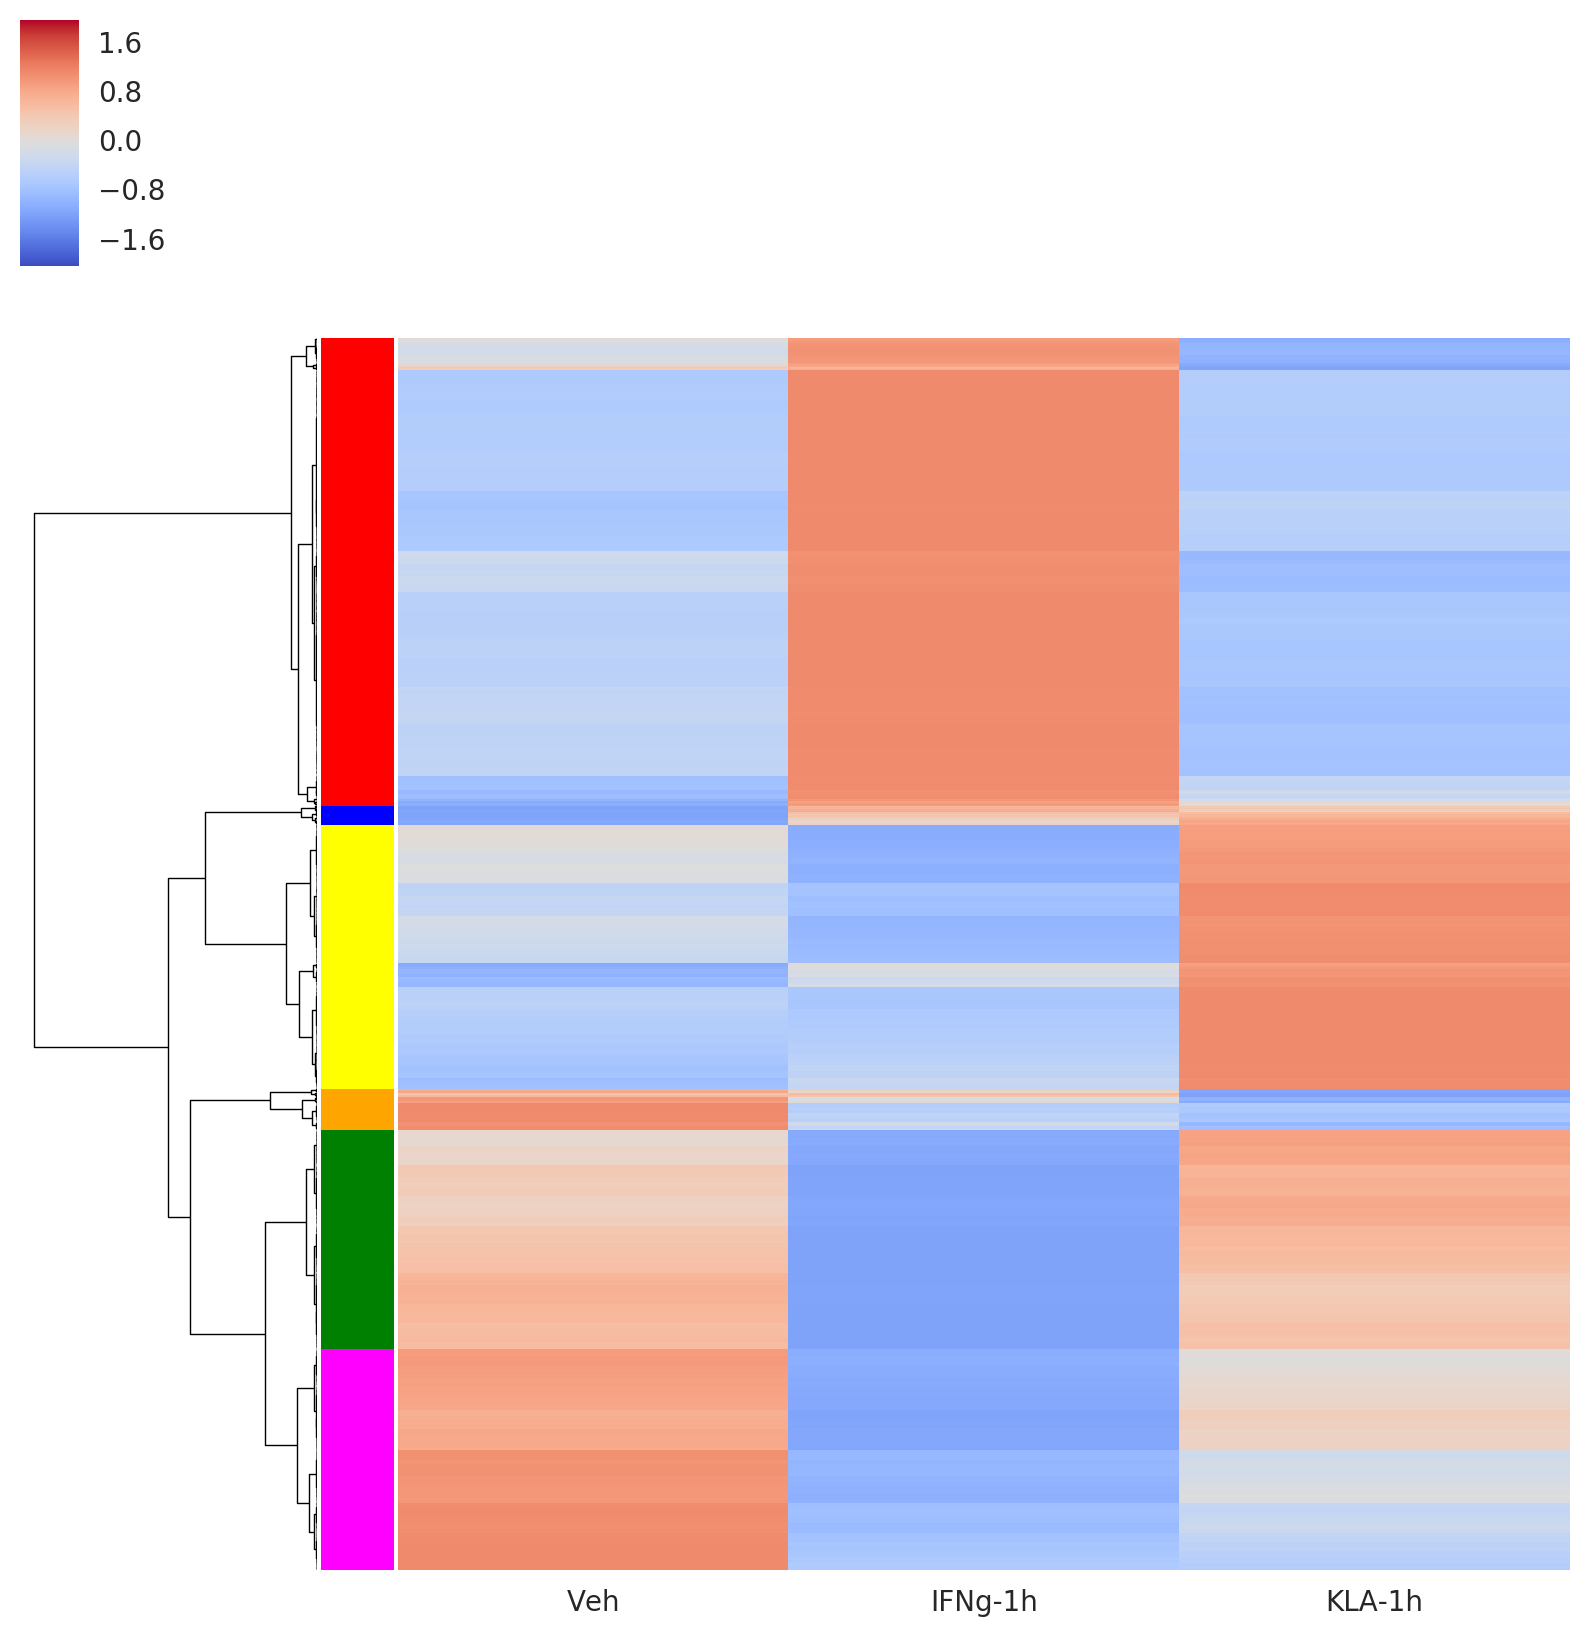

In [362]:
numRowClusters = 6
colorDict = dict(zip(range(numRowClusters),['red', 'blue', 'yellow', 'orange', 'green', 'magenta', 'grey']))
promoter_ids = annotated_frame[annotated_frame['Annotation'].str.contains('promoter')].index.values
data = annotated_mean_frame[(annotated_mean_frame.index.isin(diff_bound_peaks)) &
                            (annotated_mean_frame.ix[:,['Veh', 'IFNg-1h', 'KLA-1h']].max(axis=1) >= 16) &
                            (~annotated_mean_frame.index.isin(promoter_ids))
                           ].ix[:,['Veh', 'IFNg-1h', 'KLA-1h']]


cg=sns.clustermap(data,
               yticklabels=False,
               col_cluster=False,
               row_cluster=True,
               vmin=-2,
               vmax=2,
               cmap='coolwarm',
               z_score = 0,
               metric = 'correlation',
               method='centroid'
                  
              )
plt.close()
row_linkage = cg.dendrogram_row.linkage

row_flatCluster = scipy.cluster.hierarchy.fcluster(row_linkage, numRowClusters, criterion="maxclust")

row_colors = [colorDict[row_flatCluster[i] -1] for i in range(len(data.index))]
sns.clustermap(data, 
                row_linkage = row_linkage,
                row_colors = row_colors,
                yticklabels = False,
                col_cluster=False,
                vmin=-2,
                vmax=2,
                cmap='coolwarm',
               z_score = 0,
)

print(data.shape)

In [40]:
enhancerID_cluster_dict = dict(zip(data.index.values, row_flatCluster))
cluster_enhancerID_dict = {x:[] for x in range(1,numRowClusters+1)}
for eid in enhancerID_cluster_dict:
    ec = enhancerID_cluster_dict[eid]
    cluster_enhancerID_dict[ec].append(eid)



/gpfs/data01/glasslab/home/jtao/software/anaconda3/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


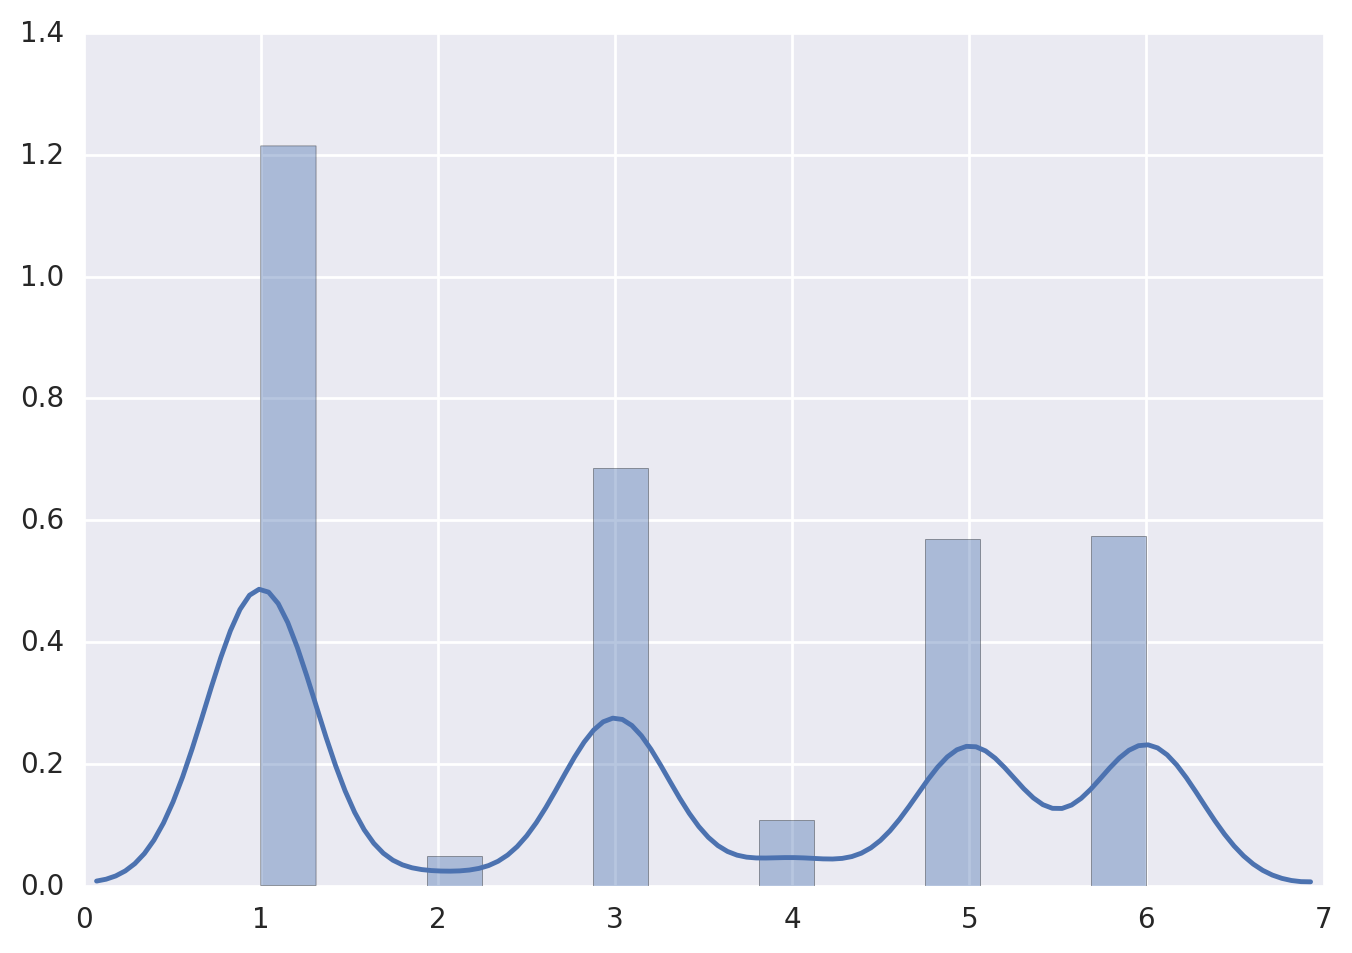

In [363]:
sns.distplot(row_flatCluster)

## Loci Overview

#### Promoters

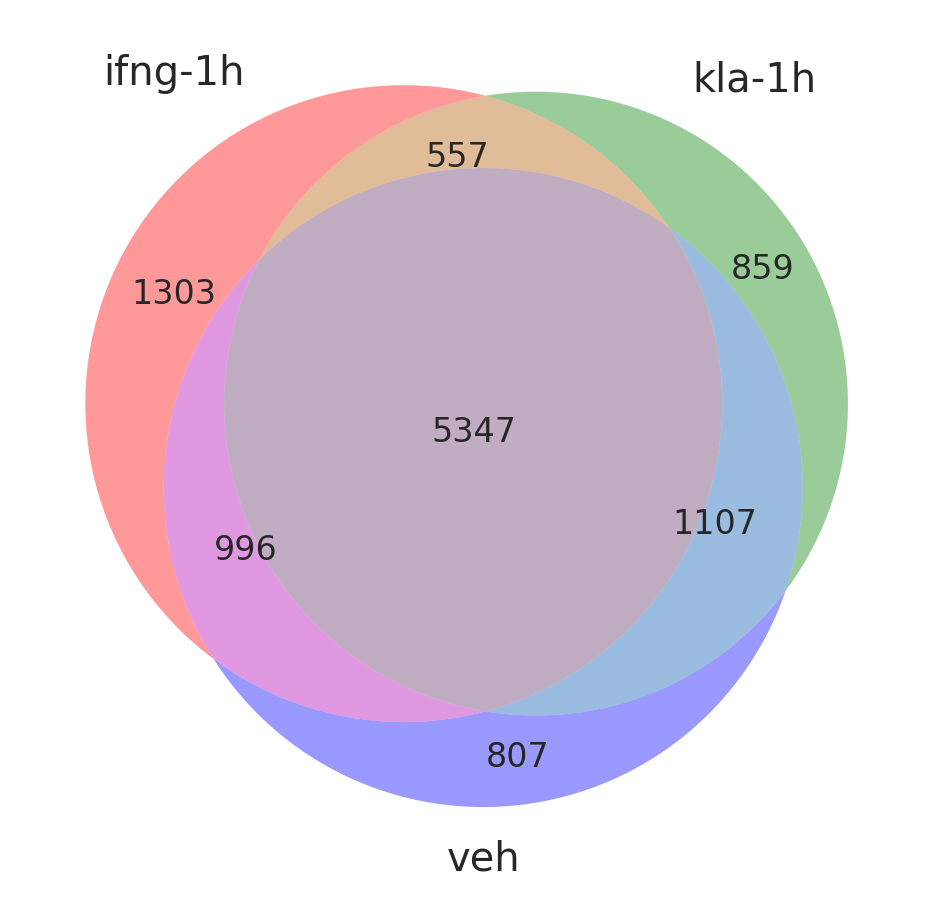

In [41]:
# treatments = summary_frame.columns[5:]
promoter_ids = annotated_frame[annotated_frame['Annotation'].str.contains('promoter')].index.values
treatments = ['ifng-1h', 'kla-1h', 'veh']
id_set_list = []
labels = []
for t in treatments:
    id_set_list.append(set(summary_frame[(summary_frame[t] > 0) &
                                         (summary_frame.index.isin(promoter_ids))].index.values))
    labels.append(t)
matplotlib_venn.venn3(id_set_list, labels)

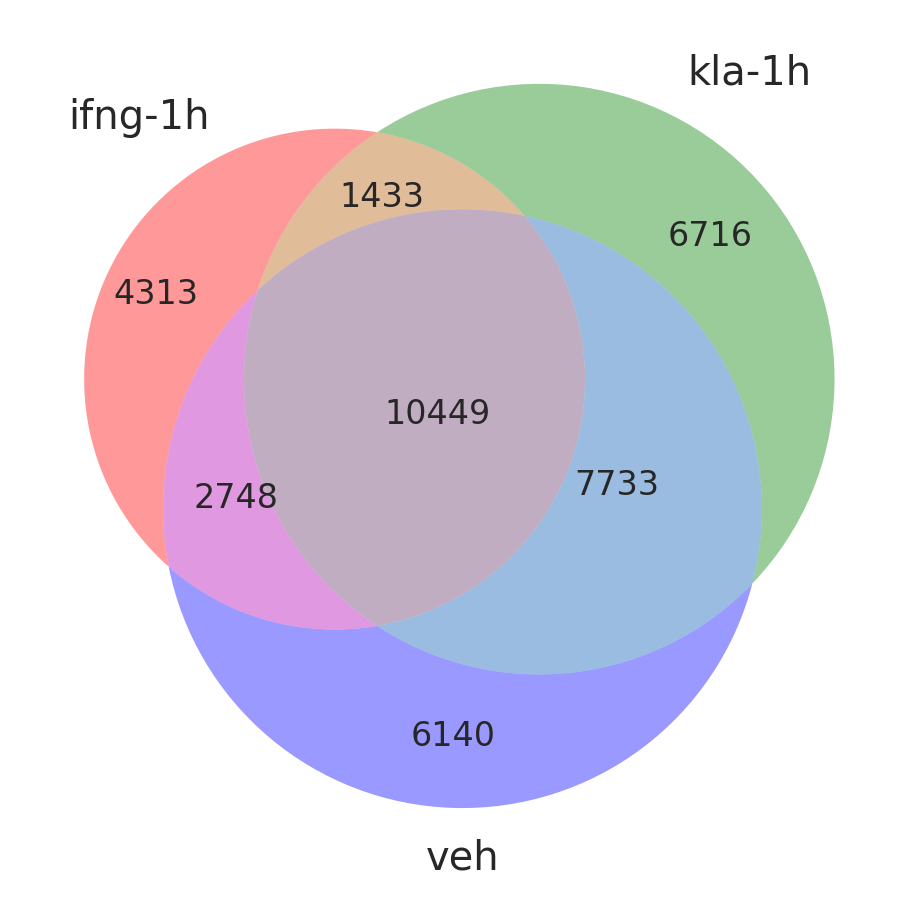

In [42]:
# treatments = summary_frame.columns[5:]
promoter_ids = annotated_frame[annotated_frame['Annotation'].str.contains('promoter')].index.values
treatments = ['ifng-1h', 'kla-1h', 'veh']

id_set_list = []
labels = []
for t in treatments:
    id_set_list.append(set(summary_frame[(summary_frame[t] > 0) &
                                         (~summary_frame.index.isin(promoter_ids))].index.values))
    labels.append(t)
matplotlib_venn.venn3(id_set_list, labels)

## Best Motif Sequence 

In [ ]:
id_motif_sequence_dict = {}
for seq_index in range(len(sequence_array_list)):
    
    msl = calc_motif_sequence(seq_index,
                        sequence_array_list, 
                        motif_score_dict, 
                        motif_score_rc_dict, 
                        motif_size_dict,
                        threshold = 0,
                        symmetric_motifs = symmetric_motifs,
                       )
    seq_id = id_list[seq_index]
    id_motif_sequence_dict[seq_id] = msl
    if seq_index % 100 == 0:
        print(seq_index)

In [ ]:
pickle.dump(id_motif_sequence_dict, open('./id_motif_sequence_dict.pickle', 'wb'))

In [ ]:
id_motif_sequence_dict = pickle.load(open('./id_motif_sequence_dict.pickle', 'rb'))

## Find Enriched Motifs with Top Motif Score

### Promoters

In [43]:
# treatments = summary_frame.columns[5:]
promoter_ids = annotated_frame[annotated_frame['Annotation'].str.contains('promoter')].index.values
treatments = ['ifng-1h', 'kla-1h', 'veh']
# motifs = sorted(topMotifScore_frame.columns.values)
motifs = motifs_to_include
threshold = 0.05

treatment_enrichedMotif_promoter_dict = {}
for t in treatments:
    treatment_enrichedMotif_promoter_dict[t] = []
    treatment_indices = summary_frame[(summary_frame[t] > 0) &
                                      (summary_frame.index.isin(promoter_ids))].index.values
    other_indices = summary_frame[(summary_frame[t] == 0) &
                                  (summary_frame.index.isin(promoter_ids))].index.values
    for m in motifs:
        treatment_scores = topMotifScore_frame.ix[treatment_indices, m].values
        other_scores = topMotifScore_frame.ix[other_indices, m].values
        is_enriched = np.mean(treatment_scores) > np.mean(other_scores)
        stat, pval = scipy.stats.ttest_ind(treatment_scores, other_scores)
        if pval < threshold/len(motifs) and is_enriched:
            treatment_enrichedMotif_promoter_dict[t].append(m)
            print(t, m,pval)
            


ifng-1h CENPB 0.000369989029031
ifng-1h E2F-related_1_merged 1.01211632273e-12
ifng-1h EGR1 6.6339820169e-36
ifng-1h More_1_merged 0.000764593710038
ifng-1h NRF1 2.43761926096e-12
ifng-1h Three-zinc_1_merged 5.55060272062e-55
ifng-1h Three-zinc_3_merged 1.46093574583e-28
ifng-1h ZBTB7A 1.08767419711e-16
kla-1h ATF4 0.000743783931572
kla-1h CEBP-related_1_merged 0.000353621641703
kla-1h CEBP-related_2_merged 7.80522702539e-07
kla-1h HD-CUT_1_merged 5.61323821185e-11
kla-1h Jun-related_1_merged 3.18155882866e-05
kla-1h MAFG::NFE2L1 0.000281482842074
kla-1h NF-kappaB-related_2_merged 6.77923461491e-05
kla-1h NFYA 1.63160566085e-16
kla-1h Nfe2l2 0.000516562015646
kla-1h Nuclear_1_merged 6.44371509095e-09
kla-1h Paired-related_3_merged 2.94849962115e-11
kla-1h STAT_1_merged 6.99038413785e-05
veh Ets-related_2_merged 1.68373700673e-06
veh NFYA 3.74624551335e-21
veh NRF1 0.000496746574716
veh Nuclear_1_merged 5.68520042663e-06


### Enhancers

In [44]:
# treatments = summary_frame.columns[5:]
promoter_ids = annotated_frame[annotated_frame['Annotation'].str.contains('promoter')].index.values
treatments = ['ifng-1h', 'kla-1h', 'veh']
# motifs = sorted(topMotifScore_frame.columns.values)
motifs = motifs_to_include
threshold = 0.05

treatment_enrichedMotif_enhancer_dict = {}
for t in treatments:
    treatment_enrichedMotif_enhancer_dict[t] = []
    treatment_indices = summary_frame[(summary_frame[t] > 0) &
                                      (~summary_frame.index.isin(promoter_ids))].index.values
    other_indices = summary_frame[(summary_frame[t] == 0) &
                                  (~summary_frame.index.isin(promoter_ids))].index.values
    for m in motifs:
        treatment_scores = topMotifScore_frame.ix[treatment_indices, m].values
        other_scores = topMotifScore_frame.ix[other_indices, m].values
        is_enriched = np.mean(treatment_scores) > np.mean(other_scores)
        stat, pval = scipy.stats.ttest_ind(treatment_scores, other_scores)
        if pval < threshold/len(motifs) and is_enriched:
            treatment_enrichedMotif_enhancer_dict[t].append(m)
            print(t, m,pval)
            if treatment == 'kla-1h' and m =='Jun-related_1_merged':
#                 sns.distplot(treatment_scores, label='KLA')
#                 sns.distplot(other_scores, label = 'Other')
                plt.boxplot([treatment_scores+0.5, other_scores])
                plt.ylabel('Motif Score')
                plt.xticks(range(1,3),['KLA', 'Other'])
#                 plt.legend()

ifng-1h CENPB 1.74357618019e-15
ifng-1h E2F-related_1_merged 1.01453830629e-141
ifng-1h EGR1 5.4856652654e-184
ifng-1h Ets-related_1_merged 5.06487798214e-43
ifng-1h Ets-related_2_merged 3.87426804476e-117
ifng-1h IRF1 2.6934125404e-25
ifng-1h IRF2 4.80699885173e-19
ifng-1h Interferon-regulatory_1_merged 2.79771195729e-14
ifng-1h More_1_merged 1.14083616127e-26
ifng-1h NRF1 7.4515263836e-73
ifng-1h PRDM1 1.57912887485e-05
ifng-1h RUNX1 1.20916173181e-13
ifng-1h STAT1::STAT2 8.01044894427e-29
ifng-1h Three-zinc_1_merged 1.47086583249e-160
ifng-1h Three-zinc_3_merged 2.14443812822e-86
ifng-1h ZBTB7A 1.75266436318e-31
kla-1h ATF4 7.99624910855e-33
kla-1h Arid5a 1.47331207485e-23
kla-1h CEBP-related_1_merged 5.21262862334e-27
kla-1h CEBP-related_2_merged 4.13719061636e-20
kla-1h Ddit3::Cebpa 3.01179361534e-13
kla-1h Forkhead_1_merged 1.94027955492e-13
kla-1h HD-CUT_1_merged 1.75690322943e-33
kla-1h Interferon-regulatory_1_merged 0.00022941568651
kla-1h Jun-related_1_merged 2.85862625135e-2

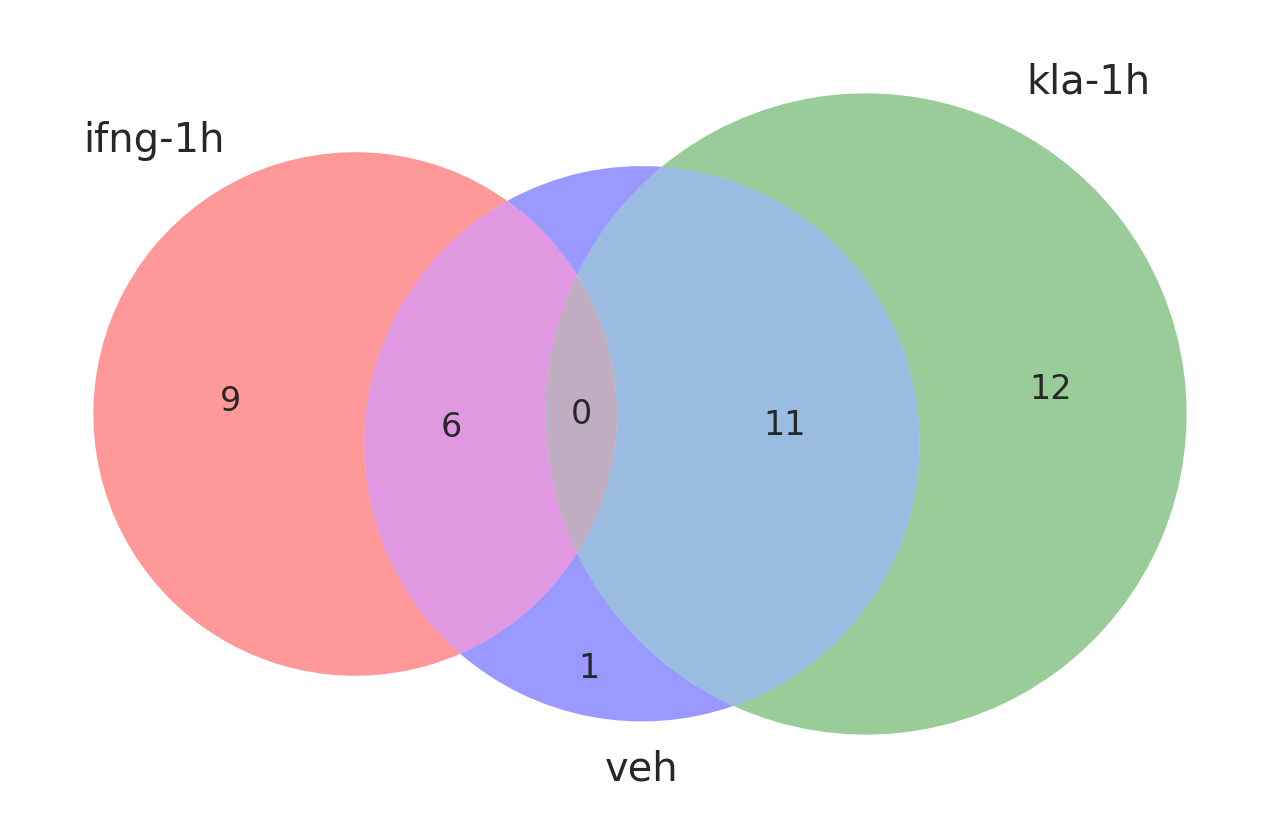

In [45]:
sorted_treatments = sorted(treatment_enrichedMotif_enhancer_dict.keys())

matplotlib_venn.venn3([set(treatment_enrichedMotif_enhancer_dict[x]) for x in sorted_treatments], set_labels=sorted_treatments)

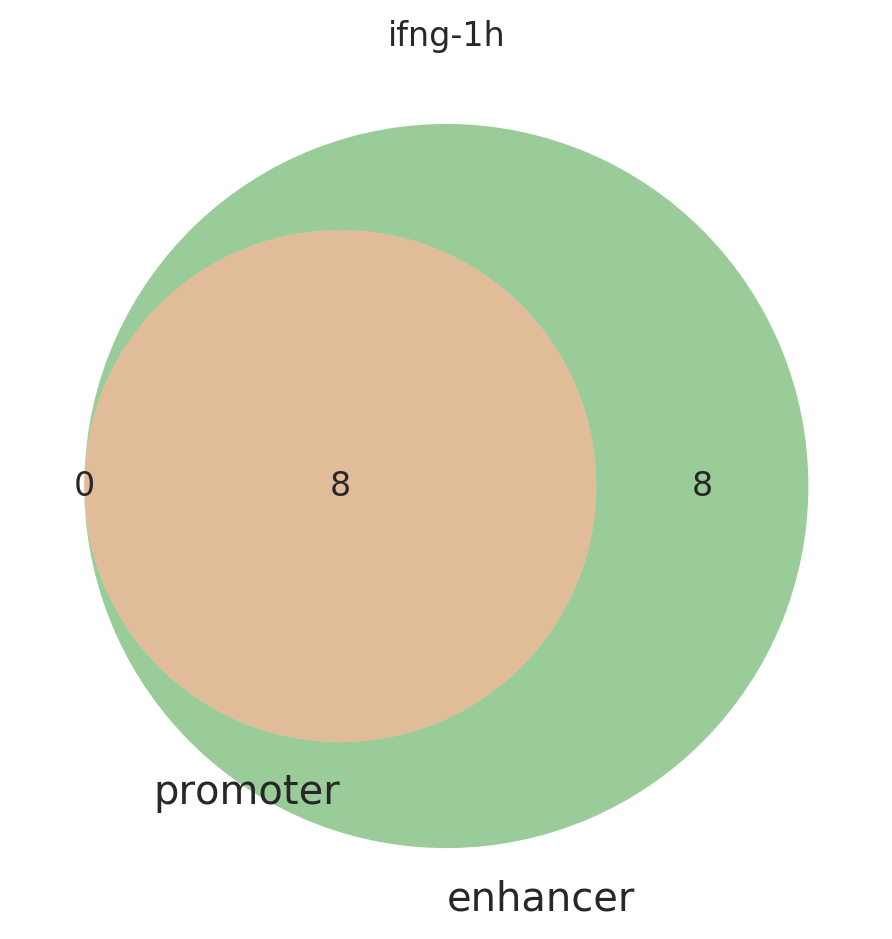

ifng-1h
enhancer specific {'IRF2', 'Interferon-regulatory_1_merged', 'Ets-related_1_merged', 'PRDM1', 'IRF1', 'Ets-related_2_merged', 'STAT1::STAT2', 'RUNX1'}
promoter specific set()


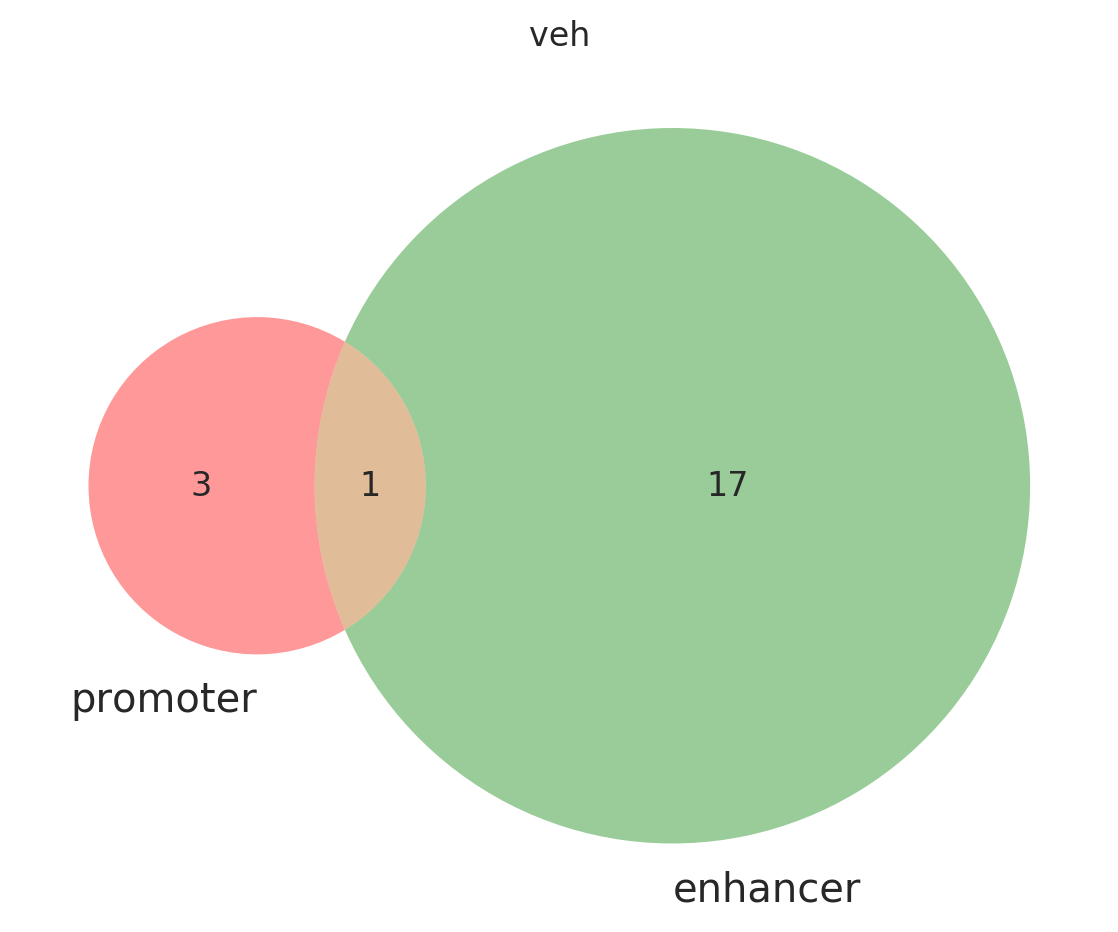

veh
enhancer specific {'MAFG', 'CEBP-related_1_merged', 'POU_2_merged', 'NFIL3', 'Forkhead_1_merged', 'Ddit3::Cebpa', 'Ets-related_1_merged', 'Paired-related_3_merged', 'PRDM1', 'CEBP-related_2_merged', 'Maf-related_1_merged', 'Arid5a', 'Regulators_1_merged', 'IRF1', 'STAT1::STAT2', 'RUNX1', 'ATF4'}
promoter specific {'NRF1', 'NFYA', 'Nuclear_1_merged'}


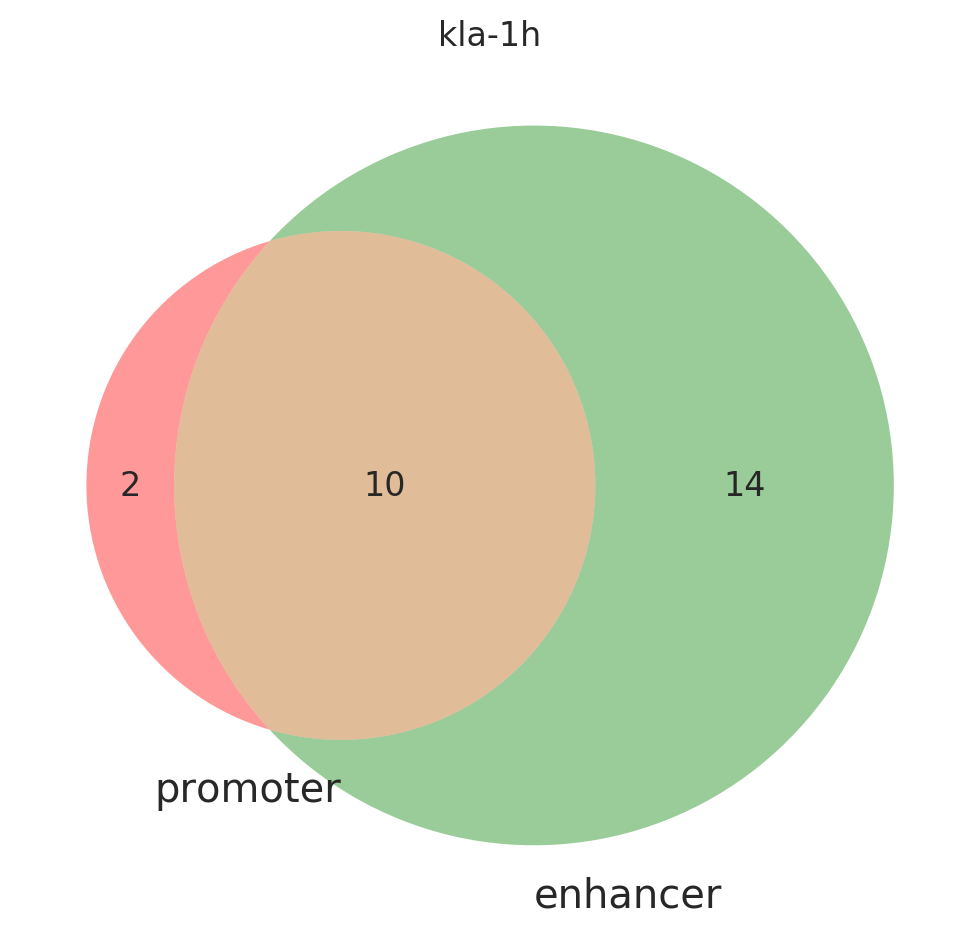

kla-1h
enhancer specific {'Jun-related_2_merged', 'MAFG', 'Nr1h3::Rxra', 'POU_2_merged', 'NFIL3', 'Forkhead_1_merged', 'Ddit3::Cebpa', 'bHLH-ZIP_1_merged', 'Interferon-regulatory_1_merged', 'NF-kappaB-related_1_merged', 'XBP1', 'Maf-related_1_merged', 'TBrain-related_1_merged', 'Arid5a'}
promoter specific {'NFYA', 'Nuclear_1_merged'}


In [46]:
for treatment in treatment_enrichedMotif_promoter_dict:
    promoter_motifs = set(treatment_enrichedMotif_promoter_dict[treatment])
    enhancer_motifs = set(treatment_enrichedMotif_enhancer_dict[treatment])
    matplotlib_venn.venn2([promoter_motifs, enhancer_motifs], set_labels=['promoter', 'enhancer'])
    plt.title(treatment)
    plt.show()
    print(treatment)
    print('enhancer specific', enhancer_motifs - promoter_motifs)
    print('promoter specific', promoter_motifs - enhancer_motifs)

In [47]:
treatment_enrichedMotif_enhancer_dict.values()
enhancer_motifs = set()
for t in treatment_enrichedMotif_enhancer_dict:
    enhancer_motifs = enhancer_motifs.union(set(treatment_enrichedMotif_enhancer_dict[t]))
enhancer_motifs = sorted(enhancer_motifs)

### Cluster Promoters On Motif Scores

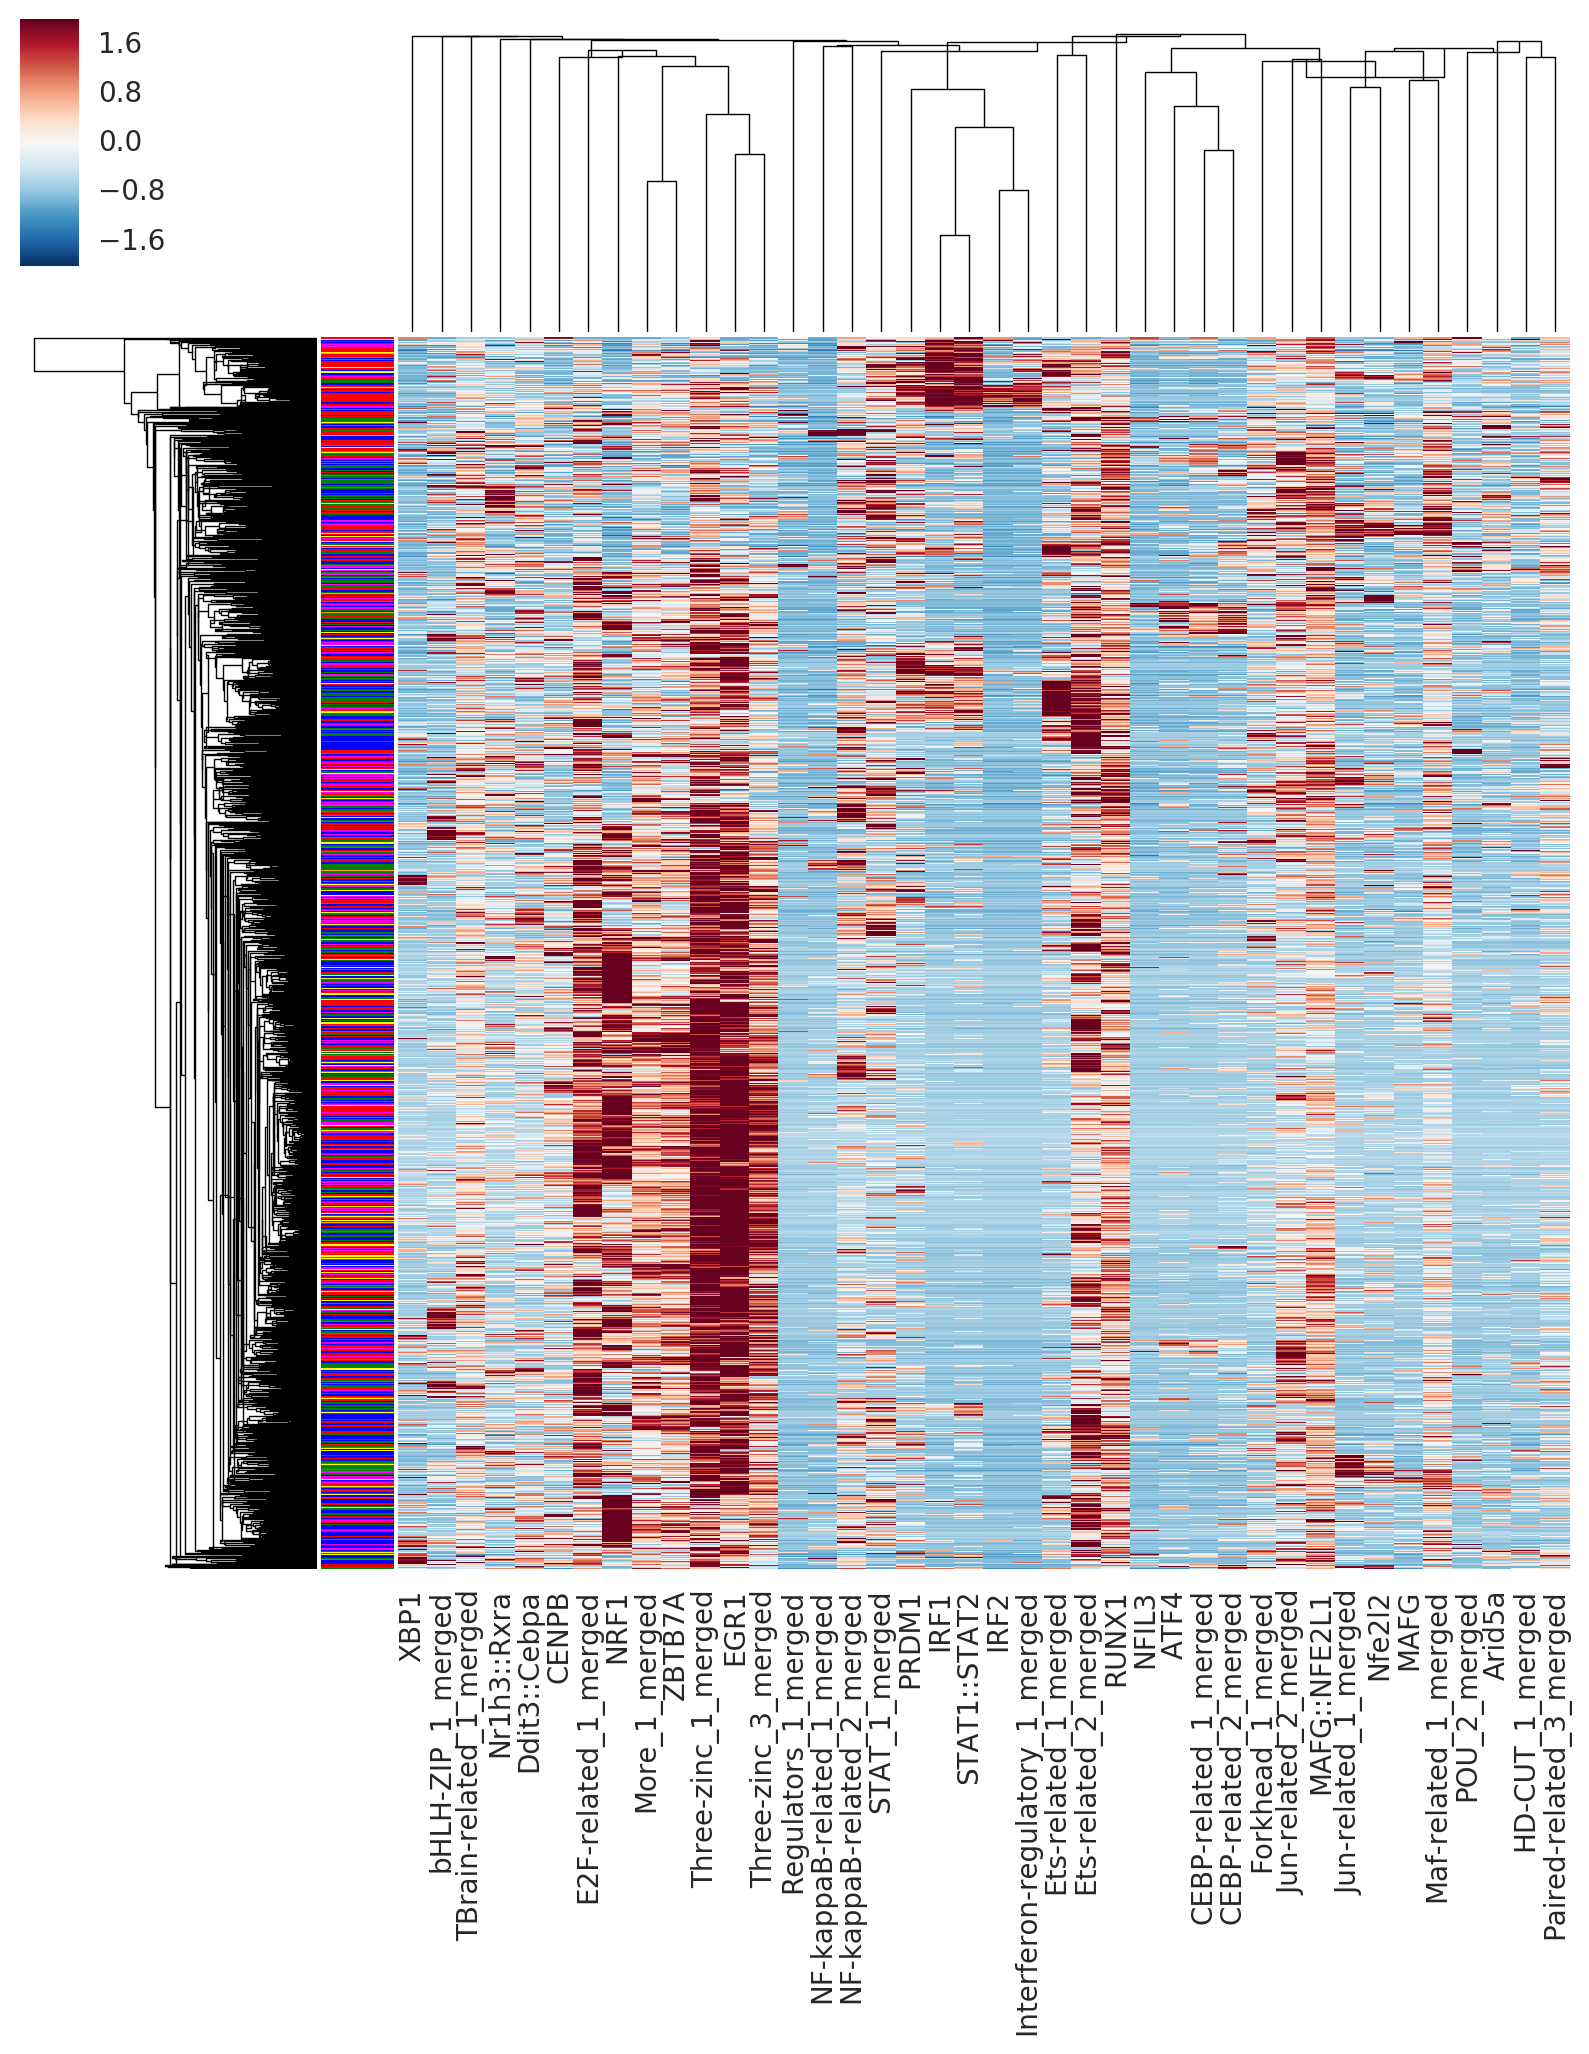

In [48]:
promoter_ids = annotated_frame[annotated_frame['Annotation'].str.contains('promoter')].index.values
colorDict = dict(zip(range(numRowClusters),['red', 'blue', 'yellow', 'orange', 'green', 'magenta', 'grey']))
data = topMotifScore_frame.ix[sorted(promoterID_cluster_dict.keys()), enhancer_motifs]
row_colors = [colorDict[promoterID_cluster_dict[i] -1] for i in data.index.values]
sns.clustermap(data,
               z_score=0,
               yticklabels=False,
               metric = 'correlation',
               method = 'centroid',
               vmin = -2,
               vmax = 2,
               row_colors= row_colors
              )

### Cluster Enhancers on Motif Scores

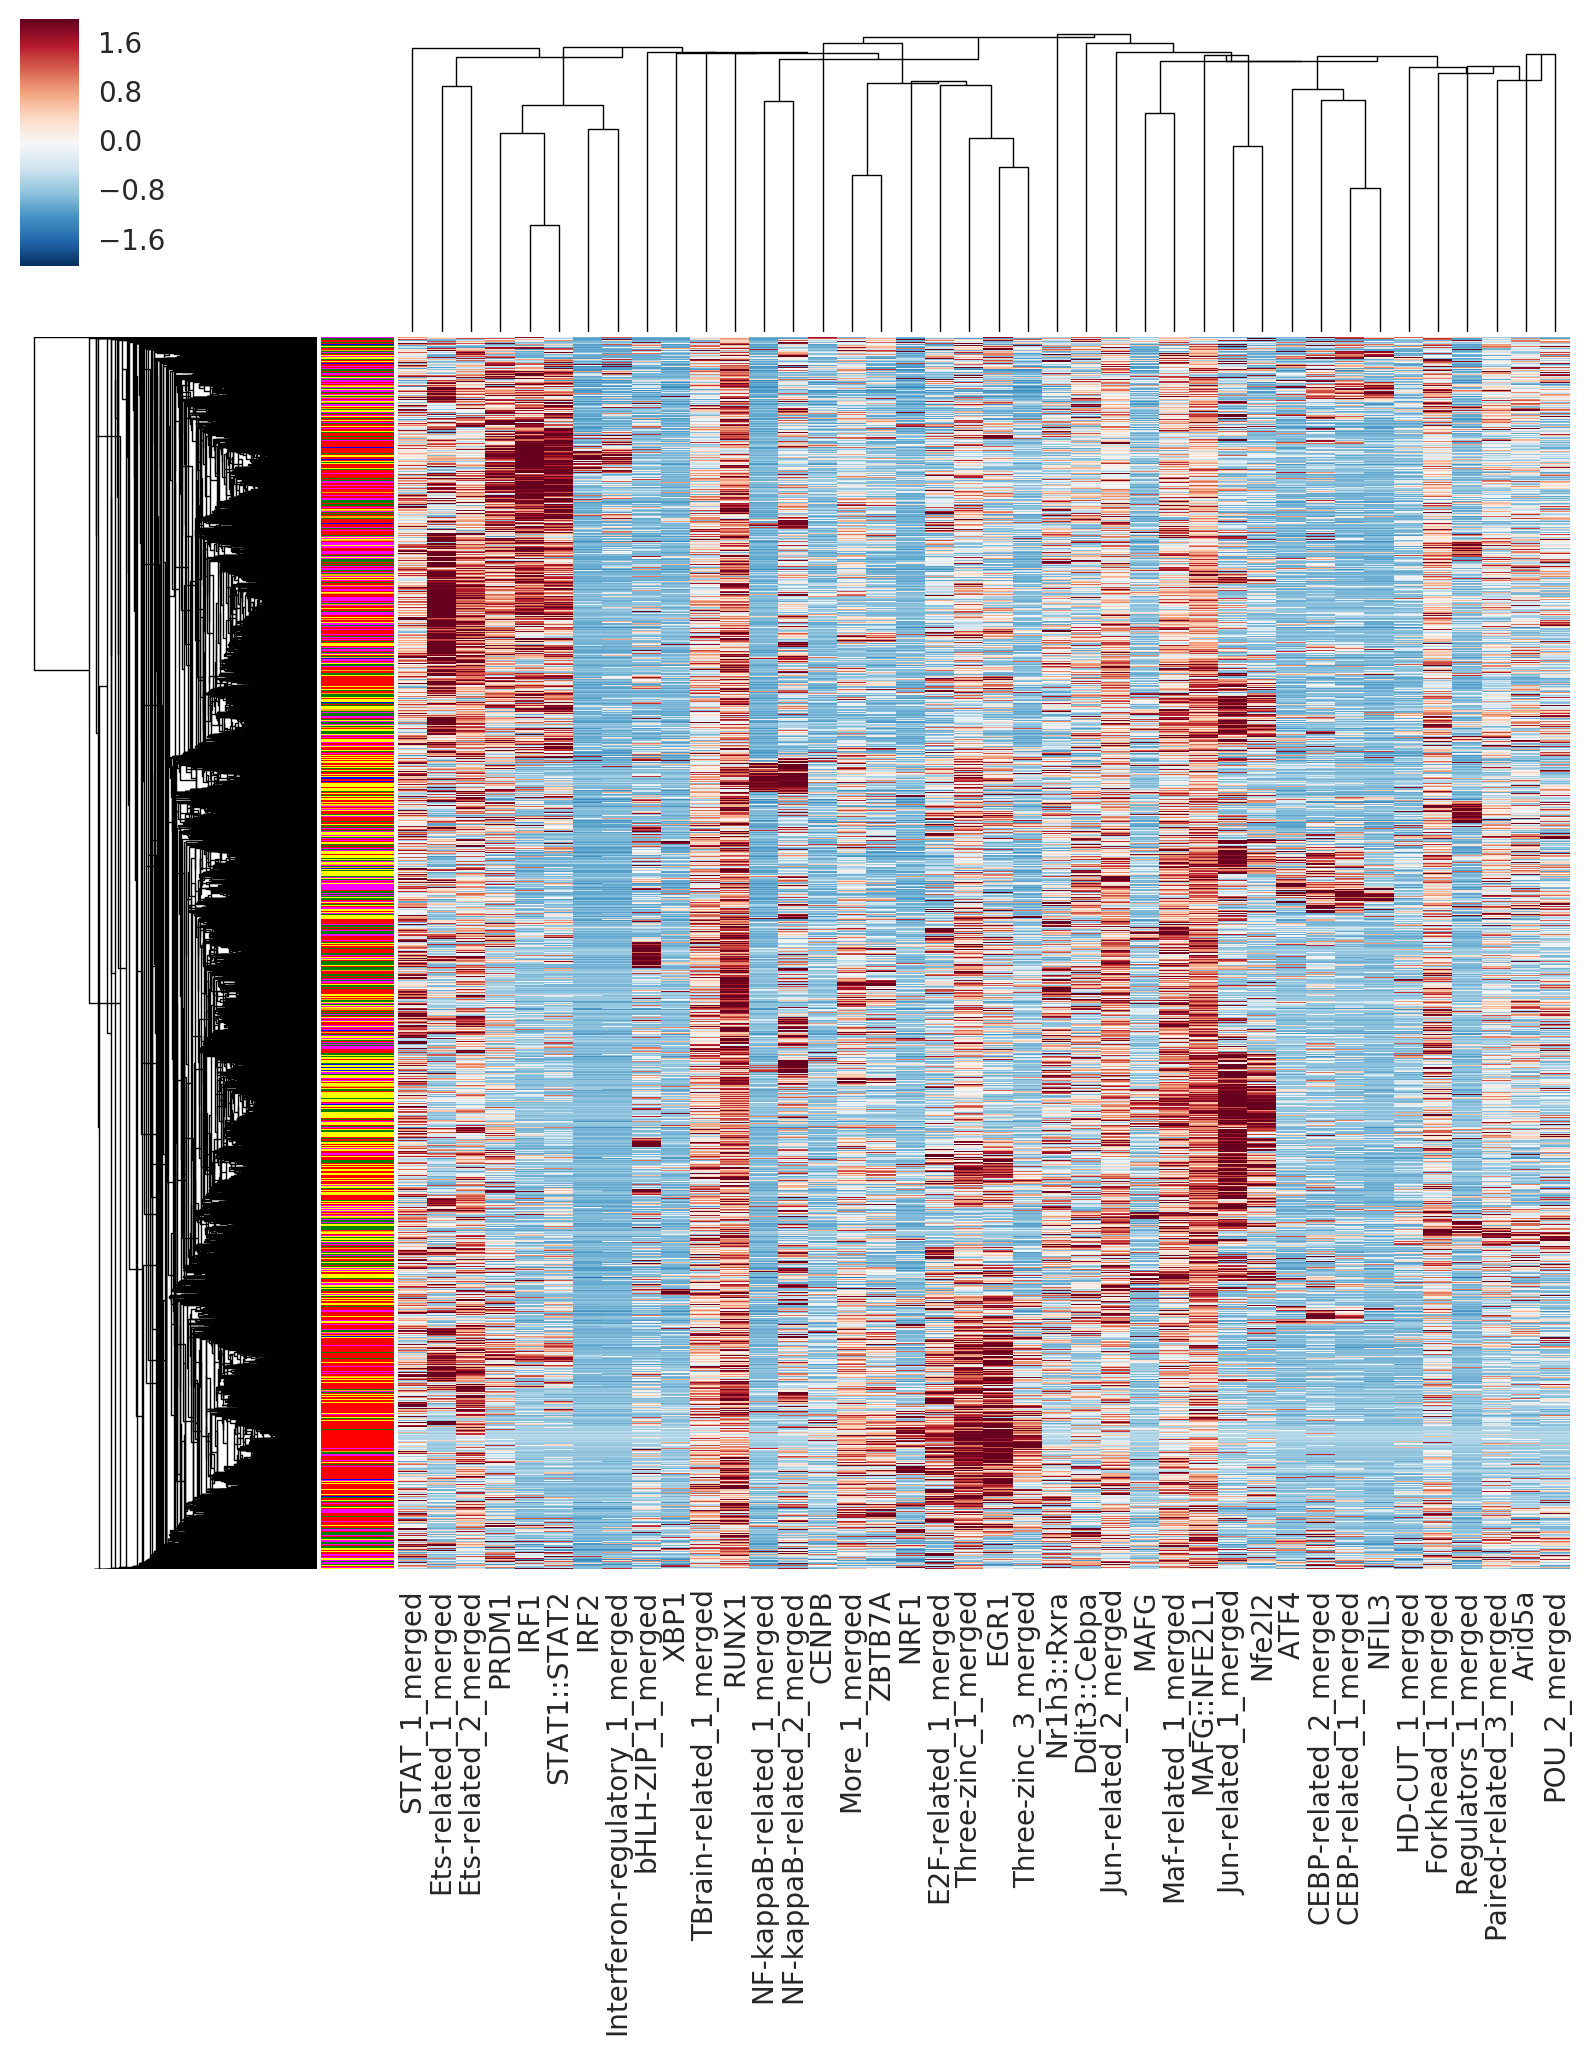

In [49]:
promoter_ids = annotated_frame[annotated_frame['Annotation'].str.contains('promoter')].index.values
data = topMotifScore_frame.ix[topMotifScore_frame.index.isin(enhancerID_cluster_dict), enhancer_motifs]
row_colors = [colorDict[enhancerID_cluster_dict[i] -1] for i in data.index.values]
sns.clustermap(data,
               z_score=0,
               yticklabels=False,
               metric = 'correlation',
               method = 'centroid',
               row_colors = row_colors,
               vmin = -2,
               vmax = 2,
              )


# New Motif Sequence Algorithm

### Refactor motif_score_dict

In [50]:
id_motifScore_forward_dict = {}
for i in range(len(id_list)):
    current_id = id_list[i]
    current_dict = {}
    for motif in motifs_to_include:
        if motif in motif_score_dict:
            current_dict[motif] = motif_score_dict[motif][i]
    id_motifScore_forward_dict[current_id] = current_dict

In [51]:
id_motifScore_reverse_dict = {}
for i in range(len(id_list)):
    current_id = id_list[i]
    current_dict = {}
    for motif in motifs_to_include:
        if motif in motif_score_rc_dict:
            current_dict[motif] = motif_score_rc_dict[motif][i]
    id_motifScore_reverse_dict[current_id] = current_dict

In [52]:
index = 1
seq_array = sequence_array_list[index]
forward_score_dict = id_motifScore_forward_dict[id_list[index]]
reverse_score_dict = id_motifScore_reverse_dict[id_list[index]]
graph, paths, paths_nodata = calc_multi_motif_sequence(seq_array, 
                              forward_score_dict, 
                              reverse_score_dict, 
                              motif_size_dict,
                              score_threshold = 5,
                              distance_threshold = 200,
                              symmetric_motifs = symmetric_motifs
                             )
print(nx.info(graph))

Name: 
Type: DiGraph
Number of nodes: 20
Number of edges: 32
Average in degree:   1.6000
Average out degree:   1.6000


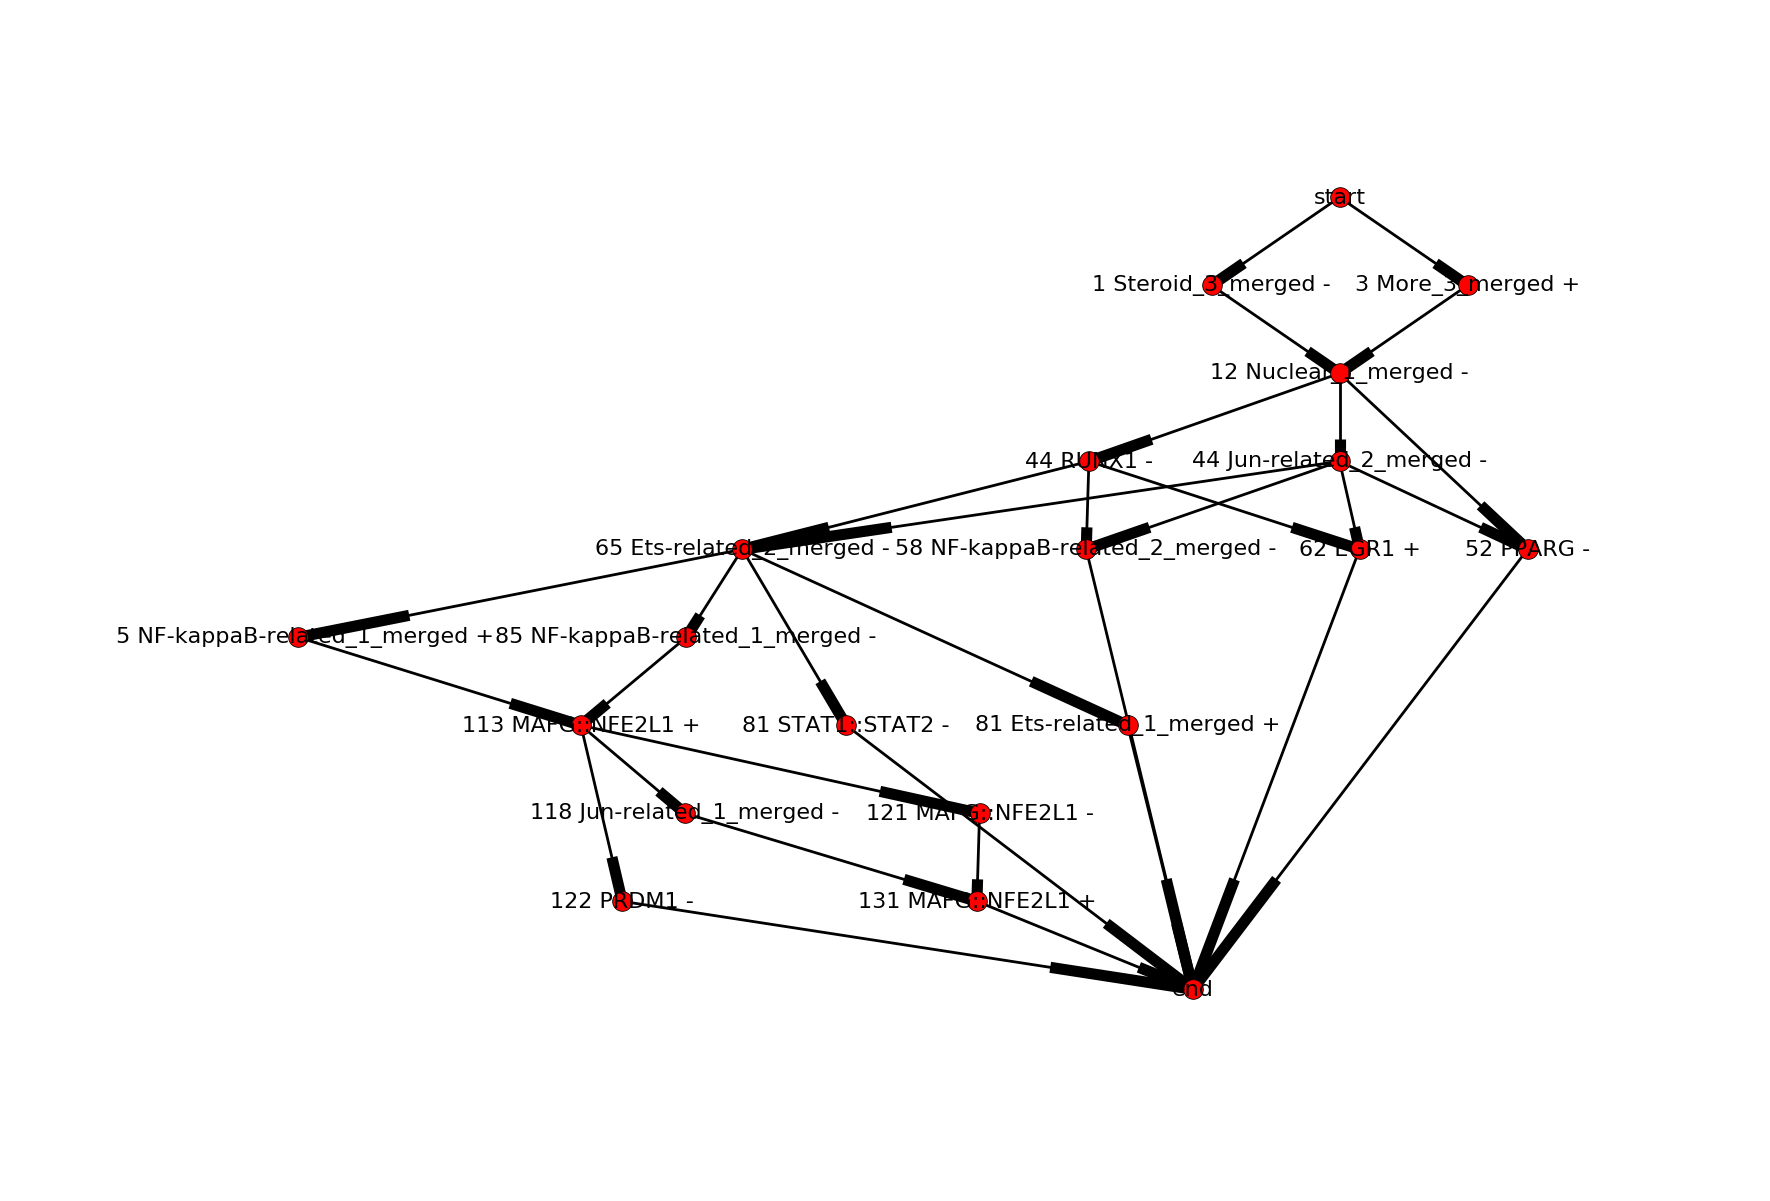

In [53]:
nx.draw(graph,
        node_size=50,
        with_labels=True,
        font_size = 8,
        pos=graphviz_layout(graph, prog = 'dot'))


## Calculate motif paths for sequences

### Promoters

In [54]:
clustered_promoterIDs = list(promoterID_cluster_dict.keys())

id_pathList_promoter_dict = {}
counter = 0
for index in range(len(clustered_promoterIDs)):
    if index % 100 ==0: 
        print(index)
    seq_id = clustered_promoterIDs[index]
    seq_array = sequence_array_list[index]
    forward_score_dict = id_motifScore_forward_dict[seq_id]
    reverse_score_dict = id_motifScore_reverse_dict[seq_id]
    result = calc_multi_motif_sequence(seq_array, 
             forward_score_dict, 
             reverse_score_dict, 
             motif_size_dict,
             score_threshold = 5,
             distance_threshold = 200,
             symmetric_motifs = symmetric_motifs
             )
    graph, paths_with_data, paths_without_data = result
    if len(paths_without_data) > 1:
        id_pathList_promoter_dict[seq_id] = paths_without_data
    else:
        counter +=1
print(counter)

0
Too many paths!!!
Too many paths!!!
Too many paths!!!
Too many paths!!!
Too many paths!!!
100
Too many paths!!!
Too many paths!!!
Too many paths!!!
200
Too many paths!!!
Too many paths!!!
300
Too many paths!!!
Too many paths!!!
Too many paths!!!
Too many paths!!!
Too many paths!!!
400
Too many paths!!!
Too many paths!!!
Too many paths!!!
500
Too many paths!!!
Too many paths!!!
600
Too many paths!!!
Too many paths!!!
Too many paths!!!
Too many paths!!!
Too many paths!!!
700
Too many paths!!!
Too many paths!!!
Too many paths!!!
800
Too many paths!!!
Too many paths!!!
Too many paths!!!
Too many paths!!!
Too many paths!!!
900
Too many paths!!!
Too many paths!!!
1000
Too many paths!!!
Too many paths!!!
Too many paths!!!
Too many paths!!!
Too many paths!!!
Too many paths!!!
1100
Too many paths!!!
Too many paths!!!
1200
Too many paths!!!
Too many paths!!!
Too many paths!!!
Too many paths!!!
1300
Too many paths!!!
Too many paths!!!
Too many paths!!!
1400
Too many paths!!!
1500
Too many paths

chr4:129058021-129058172
chr5:143909379-143909530
chr11:116024349-116024500
chr19:5567573-5567724
chr19:46056436-46056587
chr11:116490241-116490392
chr6:122308575-122308726
chr19:46395718-46395869
chr4:155223279-155223430
chr11:95384372-95384523
chr3:57735713-57735864
chr11:70130025-70130176
chr4:126321701-126321852
chr2:91202819-91202970


/gpfs/data01/glasslab/home/jtao/software/anaconda3/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


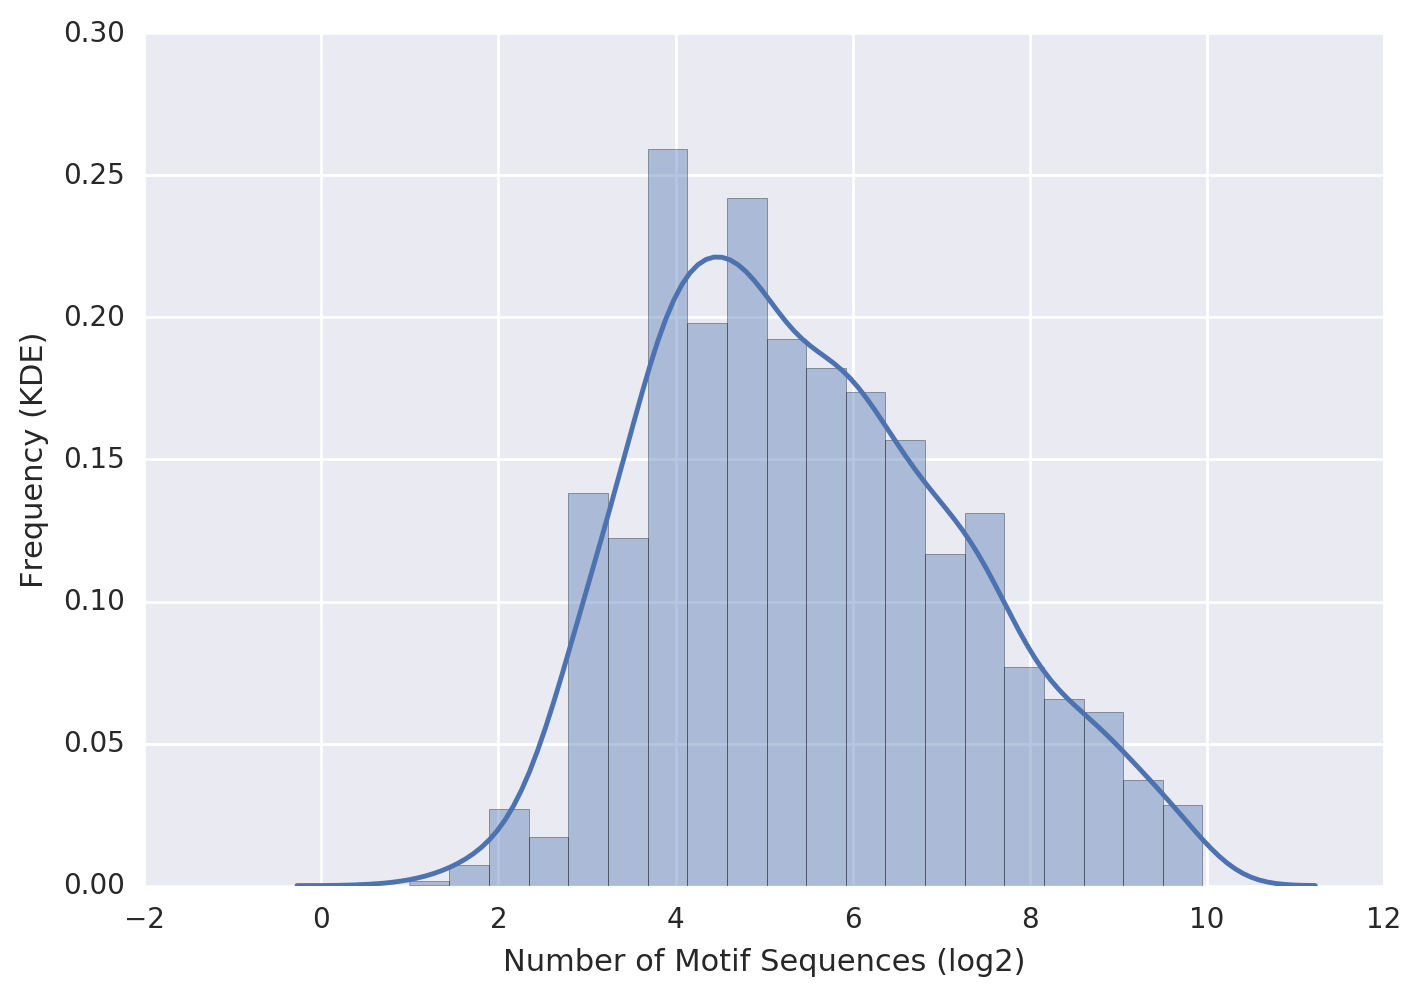

In [55]:
num_paths = []
for seq_id in id_pathList_promoter_dict:
    paths = id_pathList_promoter_dict[seq_id]
    num_paths.append(len(paths))
    if len(paths) < 5:
        print(seq_id)
sns.distplot([np.log2(x) for x in num_paths])
plt.ylabel('Frequency (KDE)')
plt.xlabel('Number of Motif Sequences (log2)')

### Enhancers

In [ ]:
clustered_enhancerIDs = list(enhancerID_cluster_dict.keys())

id_pathList_enhancer_dict = {}
counter = 0
for index in range(len(clustered_enhancerIDs)):
    if index % 100 ==0: 
        print(index)
    seq_id = clustered_enhancerIDs[index]
    seq_array = sequence_array_list[index]
    forward_score_dict = id_motifScore_forward_dict[seq_id]
    reverse_score_dict = id_motifScore_reverse_dict[seq_id]
    result = calc_multi_motif_sequence(seq_array, 
             forward_score_dict, 
             reverse_score_dict, 
             motif_size_dict,
             score_threshold = 5,
             distance_threshold = 200,
             symmetric_motifs = symmetric_motifs
             )
    graph, paths_with_data, paths_without_data = result
    if len(paths_without_data) > 1:
        id_pathList_enhancer_dict[seq_id] = paths_without_data
    else:
        counter +=1
print(counter)

/gpfs/data01/glasslab/home/jtao/software/anaconda3/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


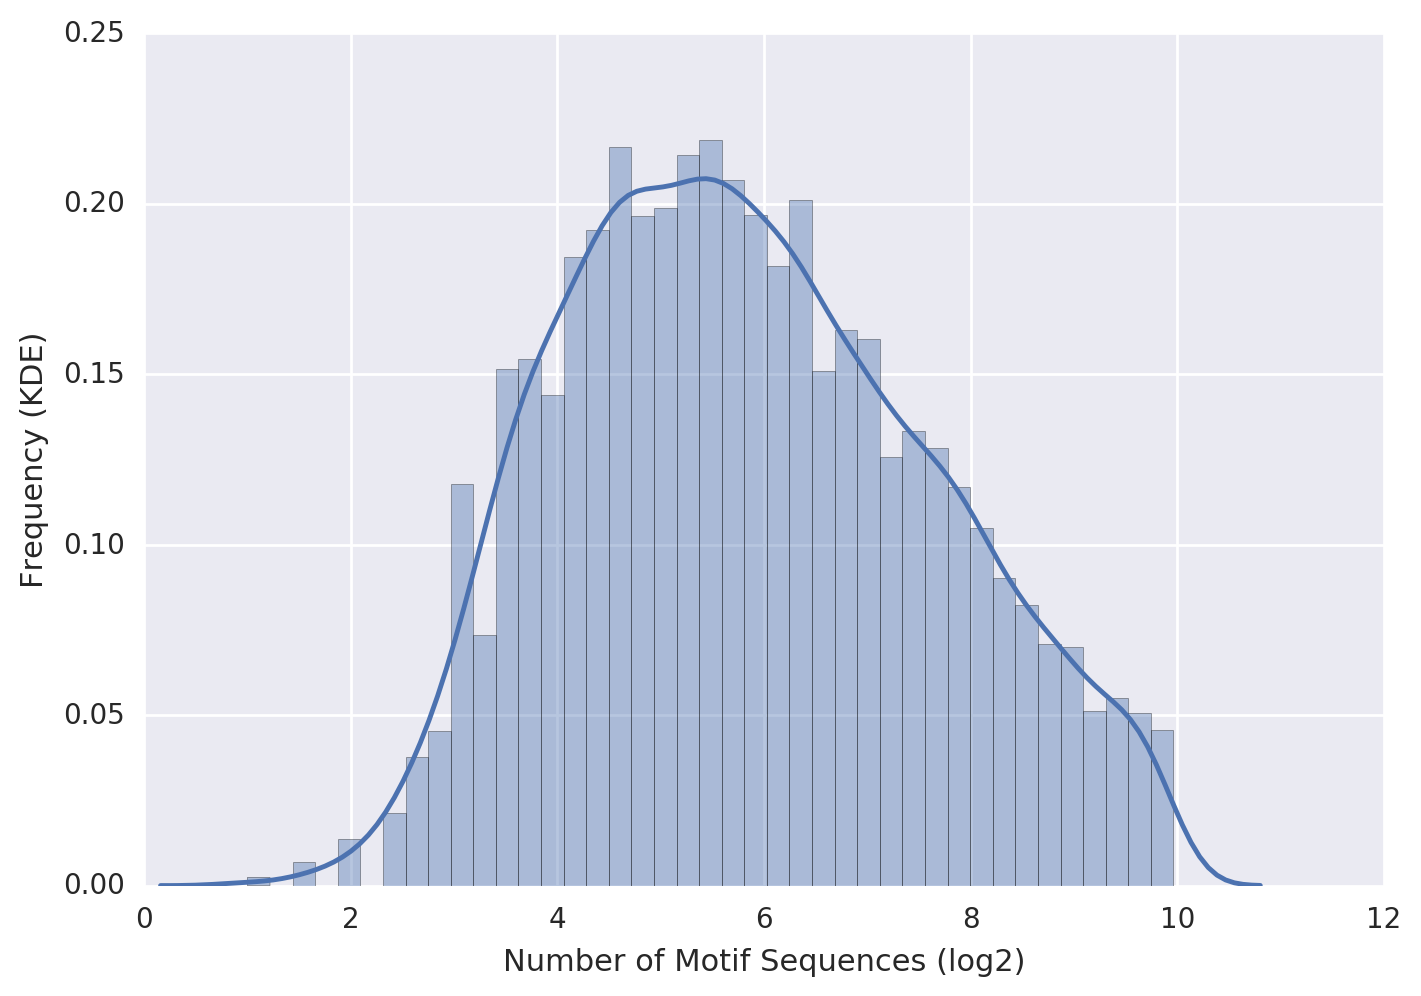

In [57]:
num_paths = []
for seq_id in id_pathList_enhancer_dict:
    paths = id_pathList_enhancer_dict[seq_id]
    num_paths.append(len(paths))
#     if len(paths) < 5:
#         print(seq_id)
sns.distplot([np.log2(x) for x in num_paths])
plt.ylabel('Frequency (KDE)')
plt.xlabel('Number of Motif Sequences (log2)')

## Pattern Finding Algorithm

### Promoter

In [58]:
min_support_level = 25

frequent_promoter_patterns = motif_prefix_span([], id_pathList_promoter_dict, min_support_level)


In [59]:
path_lengths = []
for seq_id in id_pathList_promoter_dict:
    paths = id_pathList_promoter_dict[seq_id]
    for p in paths:
        path_lengths.append(len(p))


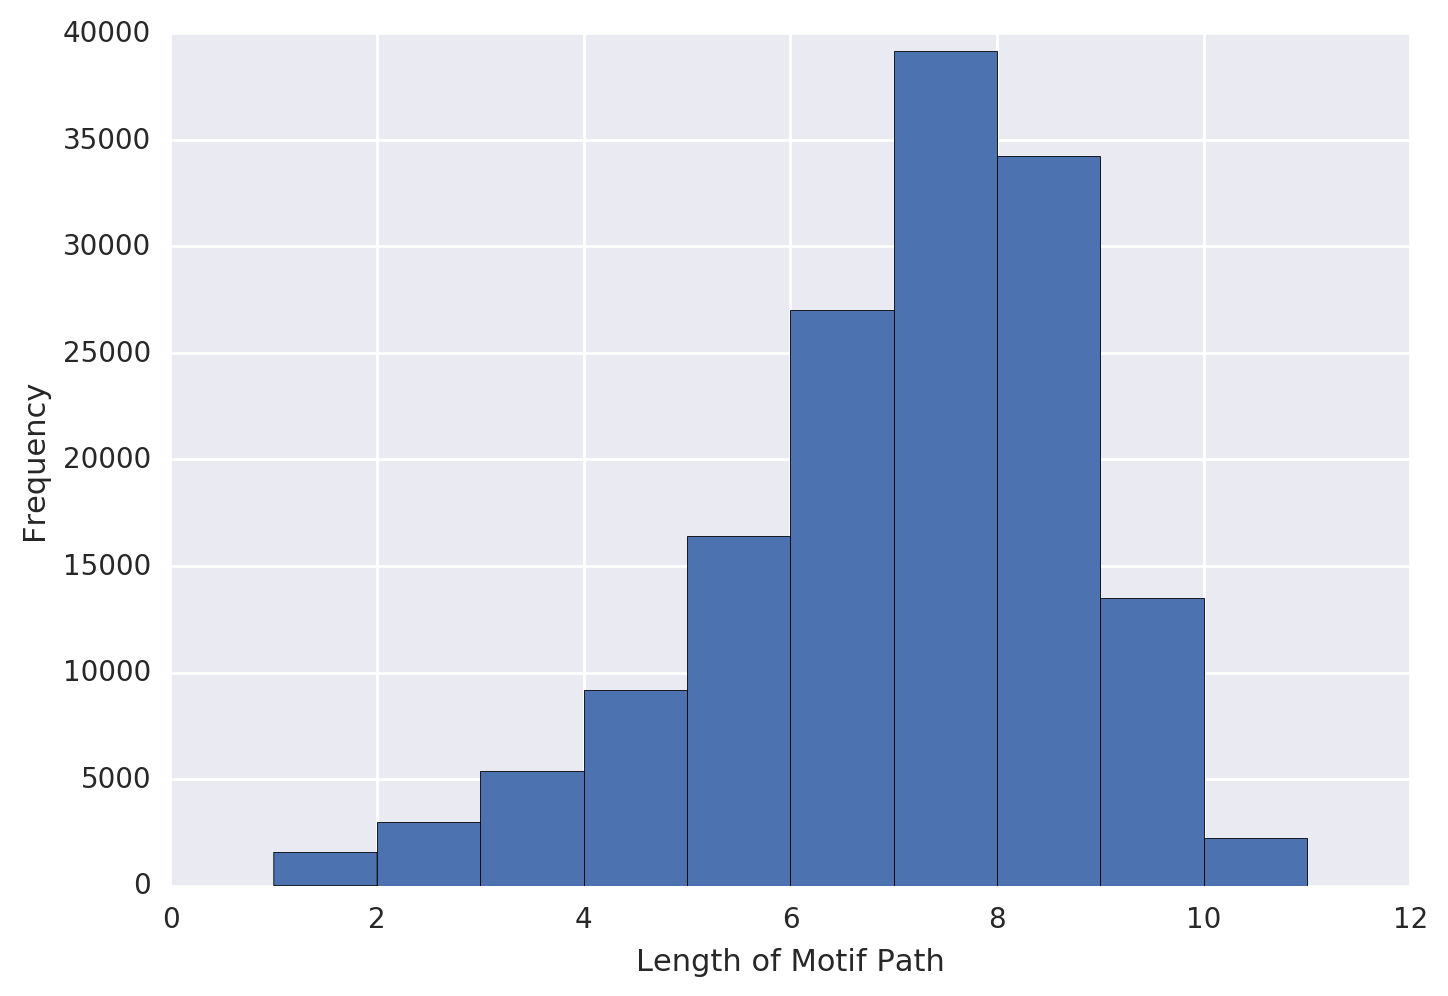

In [60]:
plt.hist(path_lengths);
plt.xlabel('Length of Motif Path')
plt.ylabel('Frequency')

In [ ]:
# sequence_pattern_promoter_table = create_pattern_sequence_table(frequent_promoter_patterns, id_pathList_promoter_dict)
start = time.time()
sequence_pattern_promoter_table = create_pattern_sequence_table(frequent_promoter_patterns, 
                                                                id_pathList_promoter_dict,
                                                                )
print('total time', time.time() - start)

In [98]:
sequence_pattern_promoter_table.to_pickle('./sequence_pattern_promoter_table.pickle')

/gpfs/data01/glasslab/home/jtao/software/anaconda3/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


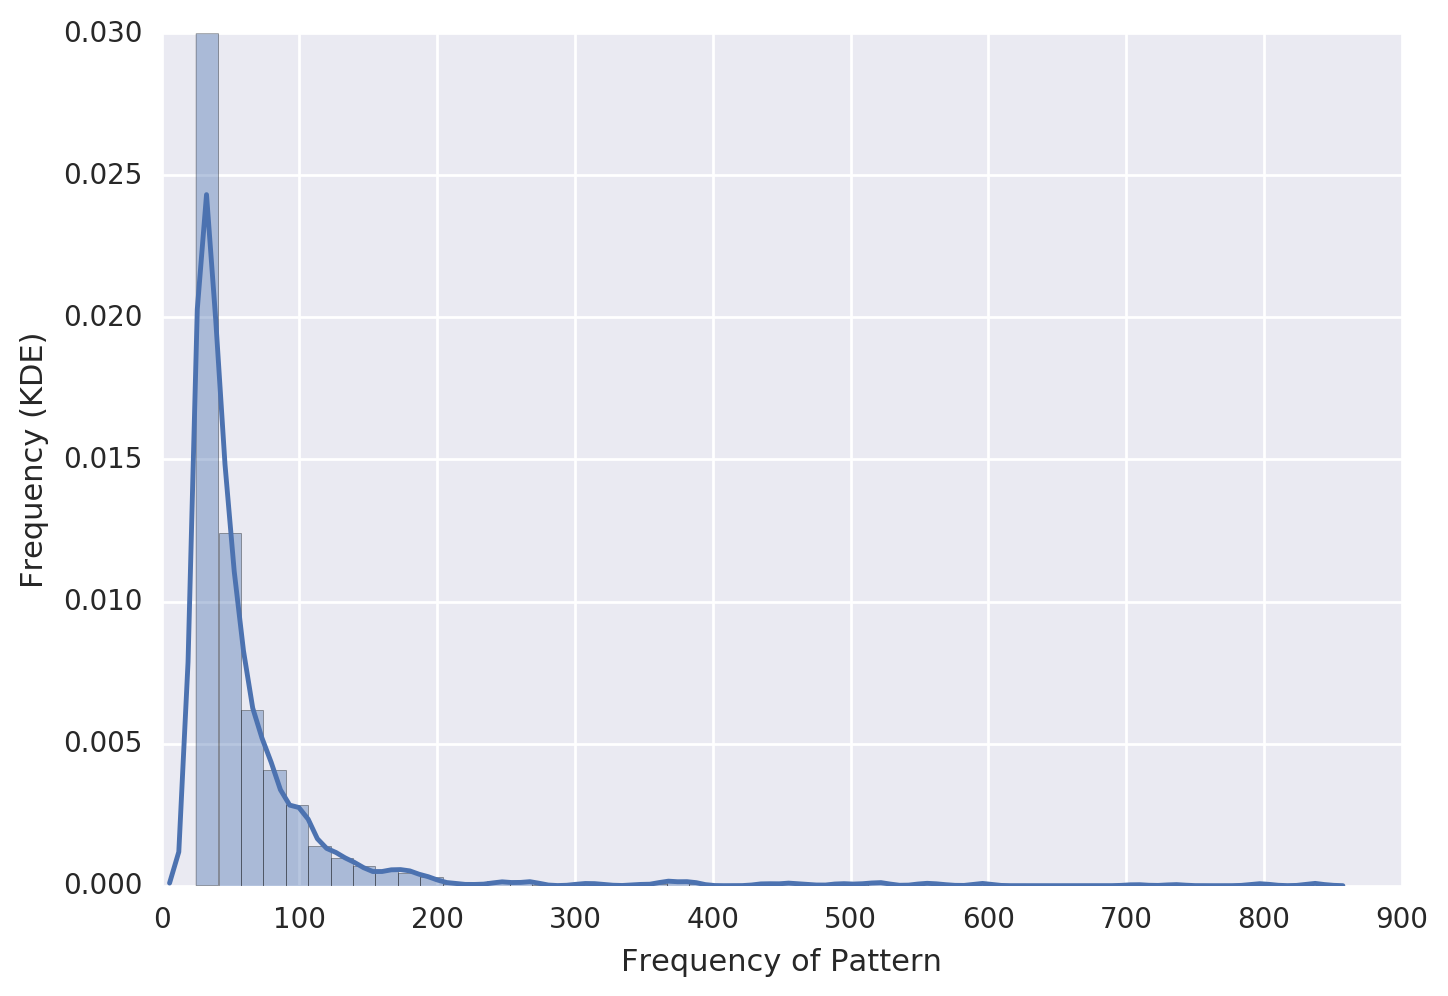

In [99]:
sns.distplot(sequence_pattern_promoter_table.sum())
plt.xlabel('Frequency of Pattern')
plt.ylabel('Frequency (KDE)')

### Enhancer

In [ ]:
min_support_level = 1000

frequent_enhancer_patterns = motif_prefix_span([], id_pathList_enhancer_dict, min_support_level)


In [ ]:
print(len(frequent_enhancer_patterns))

In [ ]:
pickle.dump(frequent_enhancer_patterns, open('./frequent_enhancer_patterns.pickle','wb'))

In [ ]:
path_lengths = []
for seq_id in id_pathList_enhancer_dict:
    paths = id_pathList_enhancer_dict[seq_id]
    for p in paths:
        path_lengths.append(len(p))


In [ ]:
plt.hist(path_lengths);
plt.xlabel('Length of Motif Path')
plt.ylabel('Frequency')

In [ ]:
sequence_pattern_enhancer_table = create_pattern_sequence_table(frequent_enhancer_patterns, id_pathList_enhancer_dict)

In [ ]:
sns.distplot(sequence_pattern_enhancer_table.sum())
plt.xlabel('Frequency of Pattern')
plt.ylabel('Frequency (KDE)')

### Link Enhancers to Promoters

In [135]:
# group by chromosome
chromosomes = annotated_frame['Chr'].unique()
chrom_enhancerPos_dict = {}
for chrom in chromosomes:
    chrom_frame = annotated_frame[annotated_frame['Chr'] == chrom].sort('Start')
    position_vals = list(zip(chrom_frame.index.values,
                              chrom_frame['Chr'],
                              (chrom_frame['Start']+chrom_frame['End'])/2
                             )
                         )
    chrom_enhancerPos_dict[chrom] = position_vals

/gpfs/data01/glasslab/home/jtao/software/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:5: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


In [181]:
dist_threshold = 100000
filtered_diff_expressed_genes = rpkm_mean_frame[(rpkm_mean_frame['Gene'].isin(diff_expressed_genes)) &
                (rpkm_mean_frame.ix[:,['Veh-1h', 'IFNg-1h', 'KLA-1h']].max(axis=1) >= 16)].ix[:,['Veh-1h', 'IFNg-1h', 'KLA-1h']].index.values
gene_position_vals = rpkm_frame[~(rpkm_frame['chr'] == 'chrY') &
                                (rpkm_frame['Gene'].isin(filtered_diff_expressed_genes))][['Gene', 'chr', 'start', 'end']].values
gene_regElements_dict = {}
counter = 0
distances = []
for t in gene_position_vals:
    gene = t[0]
    chrom = t[1]
    start = t[2]
    end = t[3]
    mid = (start + end)/2
    
    to_link = []
    
    candidates = chrom_enhancerPos_dict[chrom]
    
    for c in candidates:
        candidate_index = c[0]
        candidate_pos = c[2]
        
        distance = abs(mid - candidate_pos)
        
        if distance < dist_threshold:
            to_link.append(candidate_index)
        gene_regElements_dict[gene] = to_link
    counter +=1
    
    if counter % 100 ==0:
        print(counter)
        

100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900


In [182]:
# drop genes that don't have nearby enhancers or don't have motif path representation
counter = 0
filtered_gene_regElements_dict = {}
for x in gene_regElements_dict:
    re_ids = gene_regElements_dict[x]
    filtered_ids = [x for x in re_ids if x in id_pathList_enhancer_dict]
    if len(filtered_ids) > 0:
        filtered_gene_regElements_dict[x] = filtered_ids
    else:
        counter +=1
        print(x)
print('genes without representation', counter)
print('Total Genes Left', len(filtered_gene_regElements_dict))

Gk
Sc5d
Wdr74
Kif3c
Fas
Tmem205
Rbm7
Necap1
Ikbkb
Vps4a
Myc
Hsf1
Lmbrd1
Cybb
Idh3b
Huwe1
Plin2
Rars
Coa5
Cryl1
Dnajc21
Afg3l1
Ahcyl2
Ms4a6b
Cebpd
Scand1
Pdia6
Dnajc14
Setd3
Prep
Ppp6r1
Mtmr12
F13a1
Rab10
Tes
Itm2b
Ipo13
Fgd4
Papd7
Rchy1
Pmm2
Tor1aip2
S100a8
Pdxdc1
Acp5
Osbpl9
Rlim
Hdlbp
Sdhaf4
Mir7012
Mcm6
Isg20
Pak1
Hat1
Gas5
Rhoc
Cfb
Mogs
Marf1
Fuca2
Map1lc3a
Psmc2
2300009A05Rik
Clcn5
Sgpp1
Tmem171
Rgs19
Slc7a2
Rtp4
Atpif1
Dennd4c
Tcf4
Pes1
Fam174a
Rpl37a
Ptpra
Rab10os
LOC102640359
Tmem176b
Chmp2a
Lgals3
Lta4h
Sgk1
Cd200r4
Impact
Pa2g4
Stard8
Nap1l4
4930473A02Rik
Eprs
Nop2
Nup88
Cox16
Bcl2l2
Pgrmc1
Arhgap19
Ogfr
Fbxw17
Prpf6
Cdkn1c
Mylip
S100a6
Cox7a2l
Rad21
Bcas2
Exosc10
Xpnpep1
Iars
Aplp2
C1qc
Sema4d
Eif1ax
Sec14l1
Rell1
Stard4
Rad23b
Mdh2
Degs1
Psmc4
Gfm1
Srp72
Jak2
Rpl32l
Ebna1bp2
Chmp1b
Mrpl9
Fbxo33
Rnasel
Tcerg1
6330416G13Rik
Pim2
AI607873
Rnf128
Col18a1
Ddx54
Elavl1
Myadm
Rapgef2
Itm2c
Cited2
Rnf13
Spag9
Atp1a3
Cox7c
Flt1
Mmadhc
Ranbp3
Ago1
Marco
Tor1aip1
Zdhhc6
Hnrnpk
Rps19bp

/gpfs/data01/glasslab/home/jtao/software/anaconda3/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


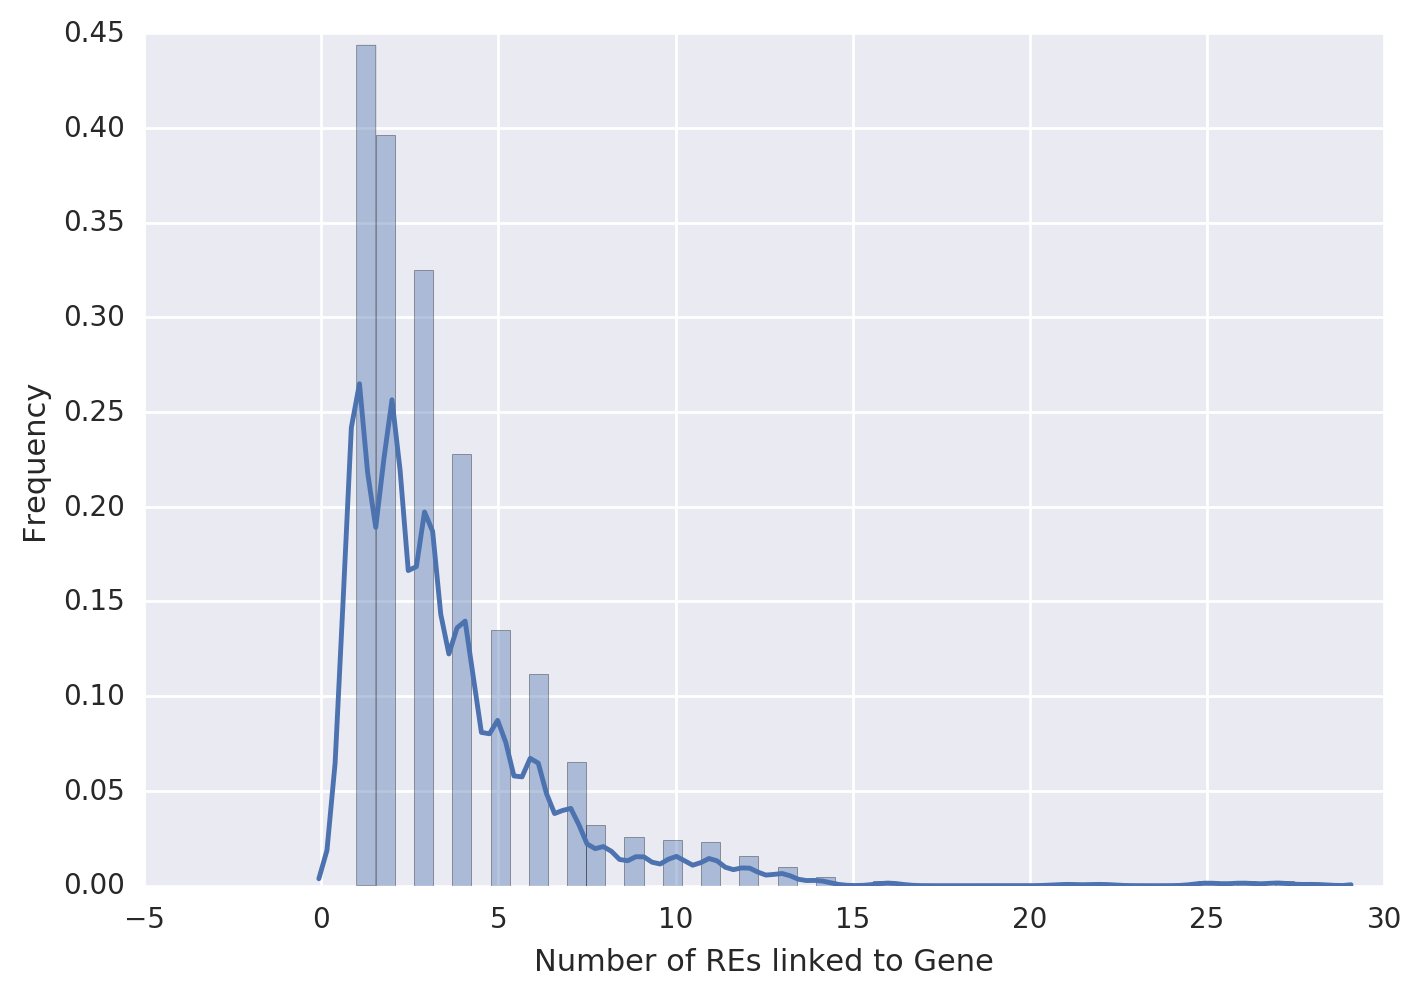

In [183]:
sns.distplot([len(filtered_gene_regElements_dict[x]) for x in filtered_gene_regElements_dict])
plt.ylabel('Frequency')
plt.xlabel('Number of REs linked to Gene')

In [189]:
# concatenate all motif paths from all regulatory elements associated with a gene
id_pathList_regElement_dict = {}

for g in filtered_gene_regElements_dict:
    regElements = filtered_gene_regElements_dict[g]
    concatenated_motif_paths = []
    for re in regElements:
        concatenated_motif_paths = concatenated_motif_paths + id_pathList_enhancer_dict[re]
    id_pathList_regElement_dict[g] = concatenated_motif_paths

In [199]:
min_support_level = 100
start = time.time()
frequent_regElement_patterns = motif_prefix_span([], id_pathList_regElement_dict, min_support_level)
print(time.time() - start)


171.79139637947083


In [203]:
len(frequent_regElement_patterns)

1757

In [204]:
start = time.time()
sequence_pattern_regElement_table = create_pattern_sequence_table(frequent_regElement_patterns, 
                                                                  id_pathList_regElement_dict
                                                                  )
print('total time', time.time() - start)

done searching for Nuclear_1_merged + * Nuclear_1_merged + 19.051619291305542
done searching for Nuclear_1_merged + * MAFG::NFE2L1 - 21.844977378845215
done searching for Nuclear_1_merged + * Nuclear_1_merged - 29.314966440200806
done searching for Nuclear_1_merged + * MAFG::NFE2L1 - * MAFG::NFE2L1 - 36.763123512268066
done searching for Nuclear_1_merged + * MAFG::NFE2L1 + 35.691951274871826
done searching for Nuclear_1_merged + * Three-zinc_1_merged - 40.29412388801575
done searching for Nuclear_1_merged + * Nuclear_1_merged + * MAFG::NFE2L1 - 44.89848756790161
done searching for Nuclear_1_merged + * Jun-related_2_merged - 42.209903717041016
done searching for Nuclear_1_merged + * Nuclear_1_merged + * RUNX1 - 46.93895864486694
done searching for Nuclear_1_merged + * RUNX1 - * MAFG::NFE2L1 + 45.47162628173828
done searching for Nuclear_1_merged + * Three-zinc_1_merged + 45.0414764881134
done searching for Nuclear_1_merged + * Nuclear_1_merged + * MAFG::NFE2L1 + 48.56373691558838
done s

In [206]:
pickle.dump(sequence_pattern_regElement_table, open('./sequence_pattern_regElement_table.pickle','wb'))

/gpfs/data01/glasslab/home/jtao/software/anaconda3/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


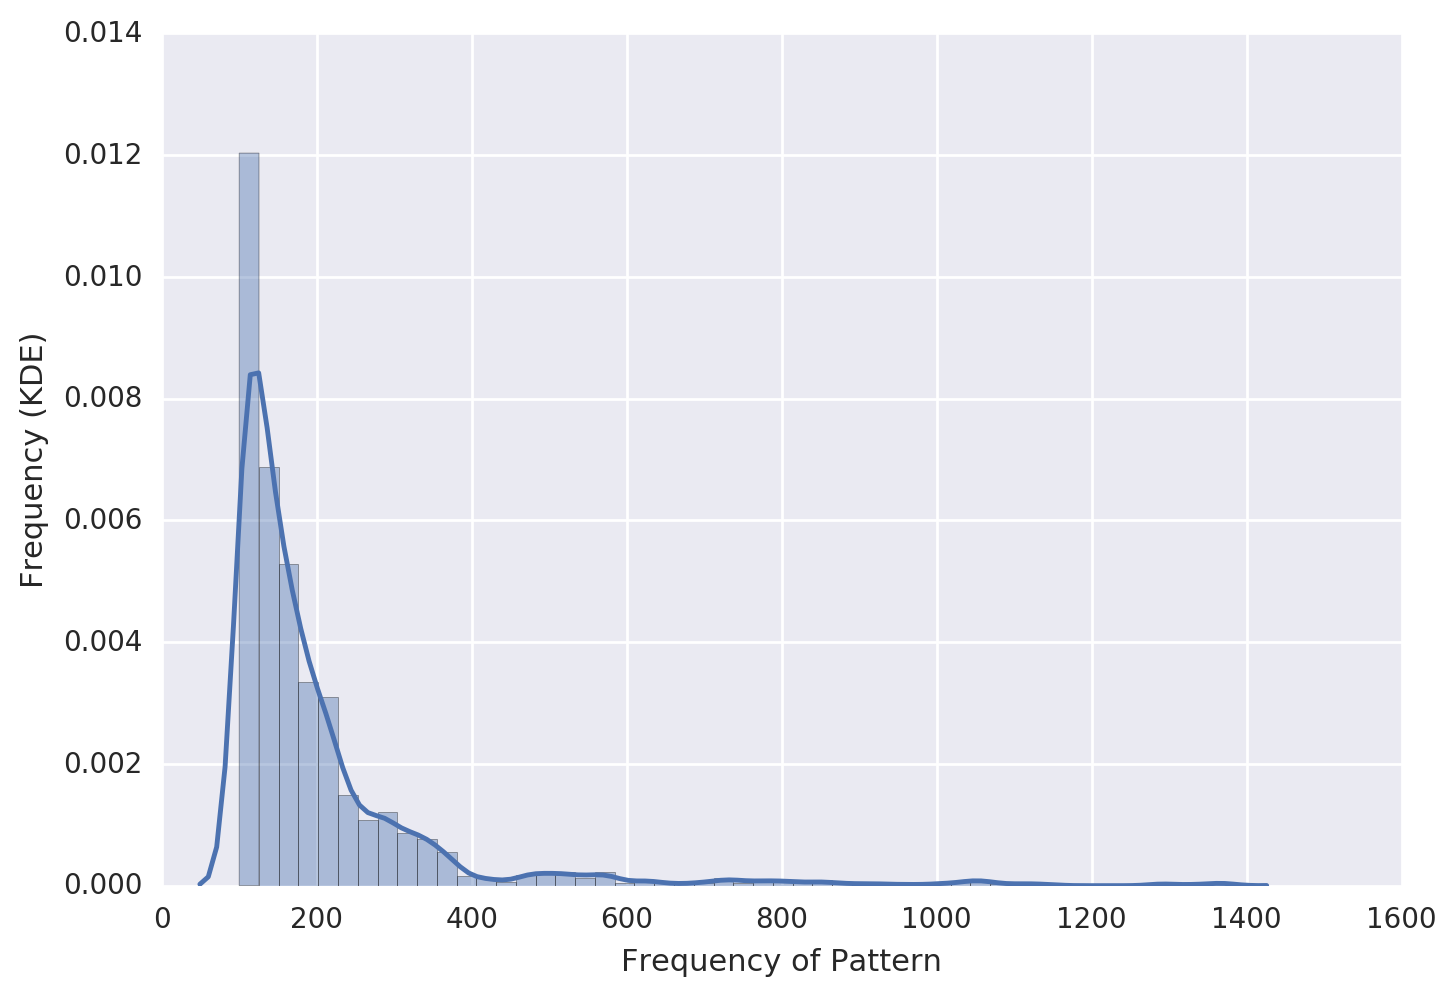

In [207]:
sns.distplot(sequence_pattern_regElement_table.sum())
plt.xlabel('Frequency of Pattern')
plt.ylabel('Frequency (KDE)')

## Decision Tree

### Promoters

In [358]:
num_iters = 20
performance_promoter_list = []
clf = tree.DecisionTreeClassifier(criterion='gini',
                                  max_depth=10, 
                                 min_samples_split=10,
                                 min_samples_leaf=10,
                                 )
labels = pd.Series([promoterID_cluster_dict[x] for x in sequence_pattern_promoter_table.index.values],
                   index= sequence_pattern_promoter_table.index.values)

for i in range(num_iters):
    training_features, test_features, training_labels, test_labels = get_split(sequence_pattern_promoter_table,
                                                                               labels, test_size=0.2)
    clf.fit(training_features, 
            training_labels
            )
    # print(clf.predict_proba(test_features, test_labels))
    test_performance = clf.score(test_features, test_labels)
    training_performance = clf.score(training_features, training_labels)
    print(test_performance, training_performance)
    performance_promoter_list.append(test_performance)

0.338607594937 0.450917797287
0.278481012658 0.425379090184
0.319620253165 0.455706304868
0.300632911392 0.46049481245
0.354430379747 0.430965682362
0.351265822785 0.446129289705
0.316455696203 0.432561851556
0.272151898734 0.454110135674
0.329113924051 0.435754189944
0.313291139241 0.462889066241
0.310126582278 0.443735035914
0.341772151899 0.451715881883
0.335443037975 0.434956105347
0.29746835443 0.489225857941
0.341772151899 0.456504389465
0.313291139241 0.445331205108
0.284810126582 0.481245011971
0.284810126582 0.453312051077
0.287974683544 0.448523543496
0.360759493671 0.447725458899


In [274]:
tree.export_graphviz(clf, 
                     out_file='tree_promoter.dot',
                     feature_names = sequence_pattern_promoter_table.columns.values)

!dot -Tpng tree_promoter.dot -o tree_promoter.png

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.900885 to fit


### Enhancers

In [349]:
num_iters = 20
performance_enhancer_list = []
clf = tree.DecisionTreeClassifier(criterion='gini',
                                  max_depth=10, 
                                 min_samples_split=10,
                                 min_samples_leaf=10,
                                 )
labels = pd.Series([enhancerID_cluster_dict[x] for x in sequence_pattern_enhancer_table.index.values],
                   index= sequence_pattern_enhancer_table.index.values)

for i in range(num_iters):
    training_features, test_features, training_labels, test_labels = get_split(sequence_pattern_enhancer_table,
                                                                               labels, test_size=0.2)
    clf.fit(training_features, 
            training_labels
            )
    # print(clf.predict_proba(test_features, test_labels))
    test_performance = clf.score(test_features, test_labels)
    training_performance = clf.score(training_features, training_labels)
    print(test_performance, training_performance)
    performance_enhancer_list.append(test_performance)

0.425179042593 0.532836384223
0.433471541651 0.536233251557
0.414624952884 0.533402528779
0.426686769695 0.538780902057
0.416886543536 0.530288733723
0.425179042593 0.536044536705
0.42706370147 0.532930741649
0.424425179043 0.536799396112
0.442894836035 0.532647669372
0.428948360347 0.531704095112
0.421032793064 0.533779958483
0.418394270637 0.537742970372
0.429702223897 0.52991130402
0.444025631361 0.529533874316
0.436863927629 0.53453481789
0.435356200528 0.536516323835
0.425555974369 0.534629175316
0.43196381455 0.531326665409
0.419525065963 0.536421966409
0.430456087448 0.531232307983


In [276]:
tree.export_graphviz(clf, 
                     out_file='tree_enhancer.dot',
                     feature_names = sequence_pattern_enhancer_table.columns.values)

!dot -Tpng tree_enhancer.dot -o tree_enhancer.png

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.106322 to fit


### Regulatory Elements

In [360]:
num_iters = 20
performance_regElement_list = []
clf = tree.DecisionTreeClassifier(criterion='gini',
                                  max_depth=10, 
                                 min_samples_split=10,
                                 min_samples_leaf=10,
                                 )
labels = pd.Series([gene_cluster_dict[x] for x in sequence_pattern_regElement_table.index.values],
                   index= sequence_pattern_regElement_table.index.values)

for i in range(num_iters):
    training_features, test_features, training_labels, test_labels = get_split(sequence_pattern_regElement_table,
                                                                               labels, test_size=0.2)
    clf.fit(training_features, 
            training_labels
            )
    # print(clf.predict_proba(test_features, test_labels))
    test_performance = clf.score(test_features, test_labels)
    training_performance = clf.score(training_features, training_labels)
    print(test_performance, training_performance)
    performance_regElement_list.append(test_performance)

0.289940828402 0.517215568862
0.340236686391 0.52245508982
0.322485207101 0.505239520958
0.301775147929 0.506736526946
0.275147928994 0.539670658683
0.340236686391 0.511976047904
0.360946745562 0.50374251497
0.331360946746 0.48877245509
0.313609467456 0.513473053892
0.319526627219 0.49251497006
0.284023668639 0.505988023952
0.334319526627 0.509730538922
0.295857988166 0.516467065868
0.310650887574 0.531437125749
0.35798816568 0.504491017964
0.343195266272 0.514221556886
0.319526627219 0.517964071856
0.295857988166 0.536676646707
0.307692307692 0.494011976048
0.310650887574 0.48877245509


In [236]:
tree.export_graphviz(clf, 
                     out_file='tree_regElement.dot',
                     feature_names = sequence_pattern_regElement_table.columns.values)

!dot -Tpdf tree_regElement.dot -o tree_regElement.pdf

/gpfs/data01/glasslab/home/jtao/software/anaconda3/lib/python3.5/site-packages/seaborn-0.7.1-py3.5.egg/seaborn/categorical.py:2171: UserWarning: The boxplot API has been changed. Attempting to adjust your arguments for the new API (which might not work). Please update your code. See the version 0.6 release notes for more info.
  warnings.warn(msg, UserWarning)


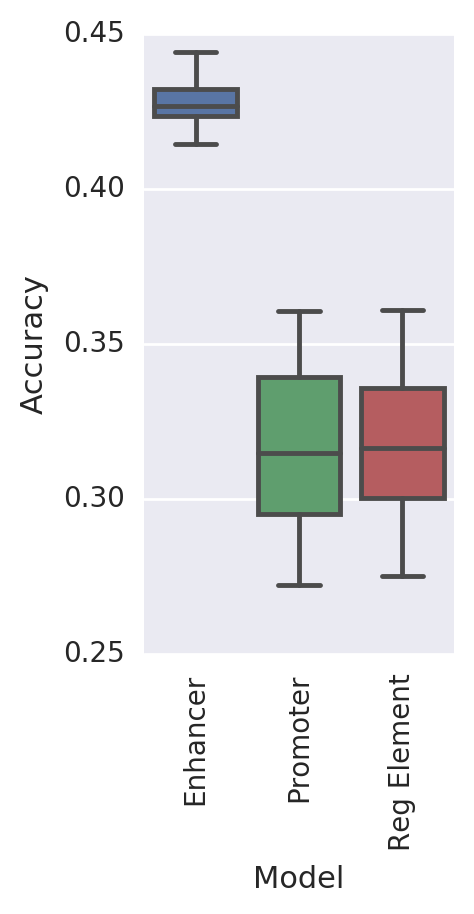

In [361]:
plt.figure(figsize=(2,4))
sns.boxplot(pd.DataFrame({'Promoter':performance_promoter_list,
                          'Enhancer':performance_enhancer_list,
                          'Reg Element': performance_regElement_list}))
plt.xticks(rotation=90)
plt.ylabel('Accuracy')
plt.xlabel('Model')

## Visualize Trees